In [239]:
import pandas as pd
import numpy as np
import re
import matplotlib.colors as color
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import researchpy as rp

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams["figure.figsize"] = (16, 7)
plt.style.use('ggplot')

In [4]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

# Overview of the data structure: 
Our main dataset [Dunnhumby - The complete journey](https://www.dunnhumby.com/careers/engineering/sourcefiles) comprises 8 csv files with the following tabular structure and content.

#### Campaign Desc
> This table gives the length of time for which a campaign runs. So, any coupons received as part of a campaign are valid within the dates contained in this table.

Description | Campaign ID | Start and End Day
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int (probably day count from study)


#### Campaign Table
> This table lists the campaigns received by each household in the study. Each household received a different set of campaigns.

Description | Campaign ID | Household key
--- | --- | ---
{TypeA, TypeB, TypeC} | int | int


#### Casual Data
> This table signifies whether a given product was featured in the weekly mailer or was part of an in-store display (other than regular product placement).

Product ID | Store ID | Week | Display location | Mailer location
--- | --- | --- | --- | --- 
int | int | int | int | String
 | | | Advertisement in in-store display? | Featured as ad in weekly mailer
 
 
#### Coupon Redemption
Household ID | Day | Coupon ID | Campaign ID 
--- | --- | --- | --- 
int | int | int | int 


#### Coupon
> This table lists all the coupons sent to customers as part of a campaign, as well as the products for which each coupon is redeemable. Some coupons are redeemable for multiple products. 

Coupon ID | Product ID | Campaign ID 
--- | --- | ---  
int | int | int 


#### Demographic
> This table contains demographic information for a portion of households. Due to nature of the data, the demographic information is not available for all households.

Age | Marital Status Code | Income | Homeowner | Household composition | Household size | Number of kids | Household Id
--- | --- | --- | --- | --- | --- | --- | --- |
(19-65+) | {A: Married, B: Single, U: Unknown} | | {Homeowner, Retired, etc.} | {Female/Male single, adults with/without kids, etc.} || (1-3+) |


#### Products
Product Id | Manufacturer Id | Departement  | Brand | Commodity description | Sub commodity description | Size
--- | --- | --- | --- | --- | --- | --- 
 | | {grocery, pastry, etc.} | {national/private} | | |
 
 
### Transaction
> This table contains all products purchased by households within this study. Each line found in this table is essentially the same line that would be found on a store receipt.

Household Id | Manufacturer Id | Week | Day | Time of Day | Product Id | Quantity | Sales value | Store Id | Retail discount | Coupon discount | Coupon match discount
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
 | | | | | | | What the shop actually gets | | | Loyalty program of retailer | Shop does not get price before discount | Shop does get price before discount

# Loading the data

Let's start by loading the data in pandas dataframes.

## Campaign description

In [5]:
df_campaign_desc = pd.read_csv('dunnhumby/campaign_desc.csv')
df_campaign_desc.columns = map(str.lower, df_campaign_desc.columns)
print(df_campaign_desc.shape)
df_campaign_desc.head()

(30, 4)


,description,campaign,start_day,end_day
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [6]:
print('Total number of campaigns: {} '.format(len(df_campaign_desc.campaign)))
print('Unique description values: {} '.format(df_campaign_desc.description.unique()))

Total number of campaigns: 30 
Unique description values: ['TypeB' 'TypeC' 'TypeA'] 


In [7]:
# Add duration column to dataframe
df_campaign_desc['duration'] = df_campaign_desc['end_day'] - df_campaign_desc['start_day'] 
df_campaign_desc.sort_values(by = ['description', 'duration']).reset_index(drop=True).head(10)

,description,campaign,start_day,end_day,duration
0,TypeA,26,224,264,40
1,TypeA,30,323,369,46
2,TypeA,13,504,551,47
3,TypeA,8,412,460,48
4,TypeA,18,587,642,55
5,TypeB,25,659,691,32
6,TypeB,21,624,656,32
7,TypeB,22,624,656,32
8,TypeB,19,603,635,32
9,TypeB,17,575,607,32


We can see that the longest campaign was on for 40 days.

In [8]:
for camp in ['TypeA', 'TypeB', 'TypeC']:
    print('Campaigns of %s range between %d and %d days' %(camp, df_campaign_desc[df_campaign_desc.description == camp].duration.min(),
                                                     df_campaign_desc[df_campaign_desc.description == camp].duration.max()))
    print('with a mean duration of %.2f days and a median duration of %.2f days. \n' 
            %(df_campaign_desc[df_campaign_desc.description == camp].duration.mean(),
              df_campaign_desc[df_campaign_desc.description == camp].duration.median()))

Campaigns of TypeA range between 40 and 55 days
with a mean duration of 47.20 days and a median duration of 47.00 days. 

Campaigns of TypeB range between 32 and 61 days
with a mean duration of 37.63 days and a median duration of 32.00 days. 

Campaigns of TypeC range between 32 and 161 days
with a mean duration of 74.50 days and a median duration of 64.00 days. 



## Campaign table

In [9]:
df_campaign_table = pd.read_csv('dunnhumby/campaign_table.csv')
df_campaign_table.columns = map(str.lower, df_campaign_table.columns)
print(df_campaign_table.shape)
df_campaign_table.head()

(7208, 3)


,description,household_key,campaign
0,TypeA,17,26
1,TypeA,27,26
2,TypeA,212,26
3,TypeA,208,26
4,TypeA,192,26


Since both campaign tables (one containing the data and the other providing further descriptions regarding each campaign) have one "key" in common, namely the `campaign id` we can join (full outer join) these two tables in order to have all information in one place.

In [10]:
df_campaign_full = pd.merge(df_campaign_desc, df_campaign_table, on='campaign', how='outer').rename(columns={"descritpion_x": "description"}).drop(columns='description_y')
# Map the lowering function to all column names
df_campaign_full.columns = map(str.lower, df_campaign_full.columns)
df_campaign_full.head(10)

,description_x,campaign,start_day,end_day,duration,household_key
0,TypeB,24,659,719,60,31
1,TypeB,24,659,719,60,149
2,TypeB,24,659,719,60,332
3,TypeB,24,659,719,60,371
4,TypeB,24,659,719,60,518
5,TypeB,24,659,719,60,553
6,TypeB,24,659,719,60,766
7,TypeB,24,659,719,60,706
8,TypeB,24,659,719,60,690
9,TypeB,24,659,719,60,676


#### Distributional analysis of how campaigns reached each household

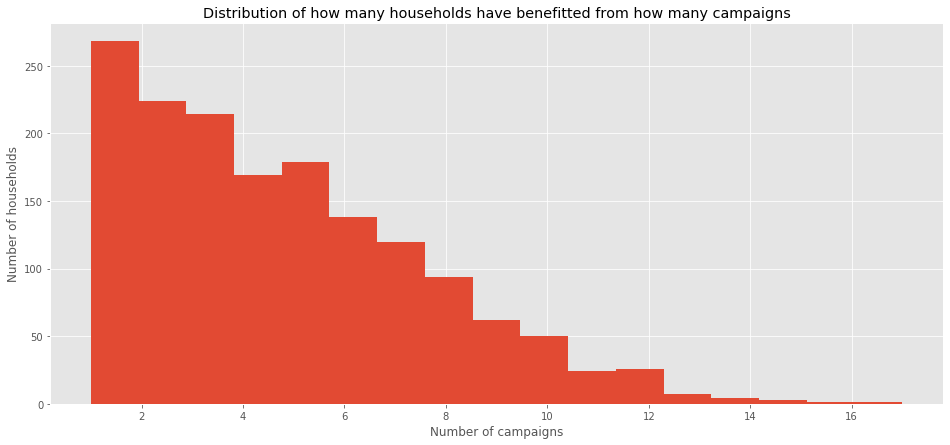

In [11]:
nbins = df_campaign_table.groupby(by = 'household_key').campaign.count().max()
df_campaign_table.groupby(by = 'household_key').campaign.count().hist(bins = nbins)
plt.title('Distribution of how many households have benefitted from how many campaigns')
plt.xlabel('Number of campaigns')
plt.ylabel('Number of households')
plt.savefig("test.svg")

In the above plot we can see, that most households have only benefited from 1 campaign and very few have made use of more than 10 campaigns.

In [12]:
df_campaign_full.groupby(by = 'household_key').campaign.count().describe()

count    1584.000000
mean        4.550505
std         2.993988
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        17.000000
Name: campaign, dtype: float64

_Mean number of campaigns:_ ~4.55

_Max number of campaigns:_ 17

_Looking at the quantiles:_

* 25% of the households have made use of 2 campaigns or less. 
* 75% of the households have made use of 6 campaigns or less.
* 95% of the households have made use of 10 campaigns or less.

Let's see how many campaigns we have.

In [13]:
print('Number of campaign: ', len(df_campaign_desc.campaign))
print('Unique description: ', df_campaign_desc.description.sort_values().unique())

Number of campaign:  30
Unique description:  ['TypeA' 'TypeB' 'TypeC']


Let's see the different campaigns over time.

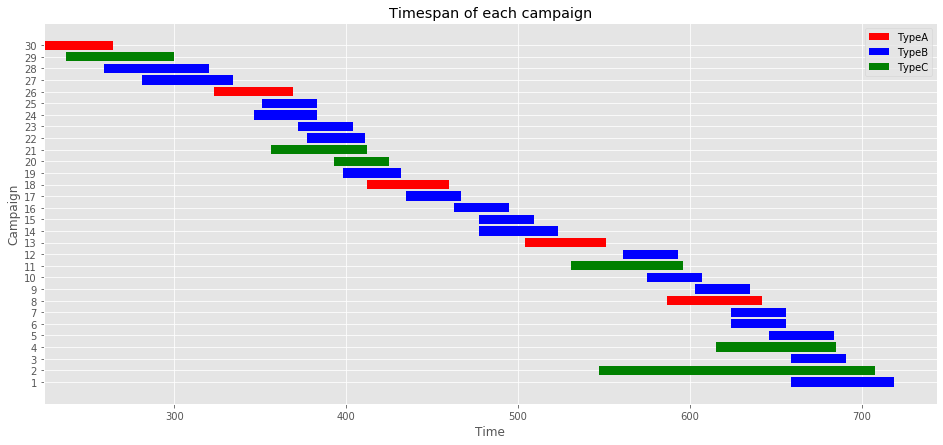

In [14]:
#Split the datas per campaign type for better visualization
beginA = df_campaign_desc[df_campaign_desc.description == 'TypeA']['start_day'].values
endA =   df_campaign_desc[df_campaign_desc.description == 'TypeA']['end_day'].values
beginB = df_campaign_desc[df_campaign_desc.description == 'TypeB']['start_day'].values
endB =   df_campaign_desc[df_campaign_desc.description == 'TypeB']['end_day'].values
beginC = df_campaign_desc[df_campaign_desc.description == 'TypeC']['start_day'].values
endC =   df_campaign_desc[df_campaign_desc.description == 'TypeC']['end_day'].values

#Plot the timespan of each campaign (note the +1 to match the indexes starting at 0 with the campaign numbers starting at 1)
plt.barh(df_campaign_desc[df_campaign_desc.description == 'TypeA'].index.values + 1,  endA-beginA, left=beginA, 
         color = 'red', label = 'TypeA')
plt.barh(df_campaign_desc[df_campaign_desc.description == 'TypeB'].index.values + 1,  endB-beginB, left=beginB, 
         color = 'blue', label = 'TypeB')
plt.barh(df_campaign_desc[df_campaign_desc.description == 'TypeC'].index.values + 1,  endC-beginC, left=beginC, 
         color = 'green', label = 'TypeC')

#Add title & legend
plt.title('Timespan of each campaign')
plt.ylabel('Campaign')
plt.yticks(df_campaign_desc.index + 1)
plt.xlabel('Time')
plt.legend()
plt.show()

## Causal data

In [15]:
df_causal = pd.read_csv('dunnhumby/causal_data.csv')
df_causal.columns = map(str.lower, df_causal.columns)
df_causal.head()

,product_id,store_id,week_no,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


## Coupon redemption

In [16]:
df_coupon_redempt = pd.read_csv('dunnhumby/coupon_redempt.csv')
df_coupon_redempt.columns = map(str.lower, df_coupon_redempt.columns)
df_coupon_redempt.head()

,household_key,day,coupon_upc,campaign
0,1,421,10000085364,8
1,1,421,51700010076,8
2,1,427,54200000033,8
3,1,597,10000085476,18
4,1,597,54200029176,18


## Coupon

In [17]:
df_coupon = pd.read_csv('dunnhumby/coupon.csv')
df_coupon.columns = map(str.lower, df_coupon.columns)
df_coupon.head()

,coupon_upc,product_id,campaign
0,10000089061,27160,4
1,10000089064,27754,9
2,10000089073,28897,12
3,51800009050,28919,28
4,52100000076,28929,25


Let's study how many coupons were redeemed for each campaign:
we start by adding a column stating if a coupon has been redeemed or not. `coupon_upc` here is the unique identifier of each coupon.

In [18]:
df_coupon['redeemed'] = df_coupon['coupon_upc'].isin(df_coupon_redempt['coupon_upc'])
df_coupon.head()

,coupon_upc,product_id,campaign,redeemed
0,10000089061,27160,4,False
1,10000089064,27754,9,True
2,10000089073,28897,12,True
3,51800009050,28919,28,True
4,52100000076,28929,25,True


In [19]:
df_coupon.redeemed[df_coupon.redeemed == True].shape[0]

108257

### Number of coupons

In [20]:
num_redempt_coupons = df_coupon.redeemed[df_coupon.redeemed == True].shape[0]
redemption_rate = num_redempt_coupons / df_coupon.shape[0] * 100
print("{} of {} coupons in total were actually redeemed, which corresponds to a redemption rate of {} %.".format(num_redempt_coupons,df_coupon.shape[0], round(redemption_rate,2)))

108257 of 124548 coupons in total were actually redeemed, which corresponds to a redemption rate of 86.92 %.


The above rate is suprisingly high...

So let us have a look how many coupons were distributed within the course of each campaign.

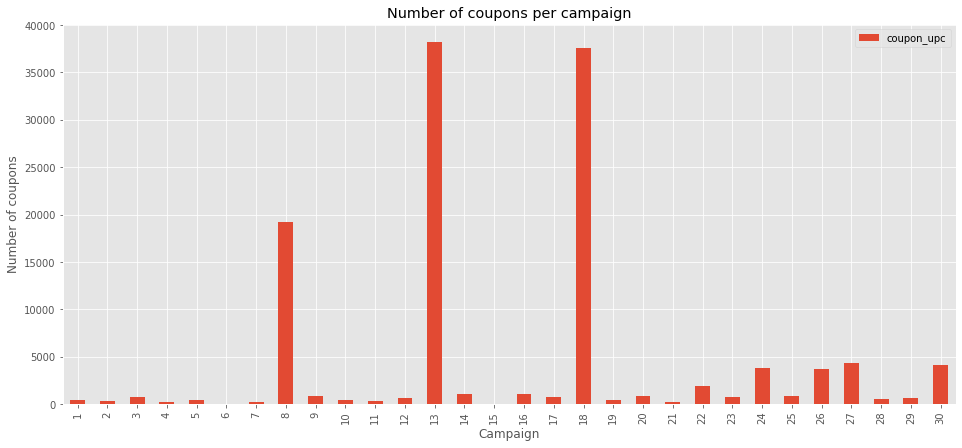

In [21]:
df_coupon.groupby(by = 'campaign').count().plot.bar(y = 'coupon_upc')
plt.xlabel('Campaign')
plt.ylabel('Number of coupons')
plt.title('Number of coupons per campaign')
plt.show()

We notice there are definetely some campaigns with way more coupons than others. Is this related to the type of campaign?

### Amount of coupons per campaign

We can now move to more advanced analysis. Let's start by combining this data with the coupon data.

In [22]:
df_campaign_desc.sort_values(by = 'campaign', inplace = True)
df_campaign_desc.set_index(keys = 'campaign', drop = True, inplace = True)
df_campaign_desc['distributed'] = df_coupon.groupby(by = 'campaign').redeemed.count() #Number of coupons distributed
df_campaign_desc['redeemed'] = df_coupon[~df_coupon['redeemed']].groupby(by = 'campaign').redeemed.count() #Number of coupons redeemed
df_campaign_desc.fillna(0, inplace = True) 
df_campaign_desc['beneficiary'] = df_campaign_table.groupby(by = 'campaign').description.count() #Number of beneficiary households
df_campaign_desc.head()

,description,start_day,end_day,duration,distributed,redeemed,beneficiary
campaign,,,,,,,
1,TypeB,346,383,37,383,363.0,13
2,TypeB,351,383,32,301,78.0,48
3,TypeC,356,412,56,740,392.0,12
4,TypeB,372,404,32,200,84.0,81
5,TypeB,377,411,34,443,97.0,166


Let's observe these results in a bar plot. For each campaign we plot the amount of coupon distributed and redeemed, and we add the type of the campaign.

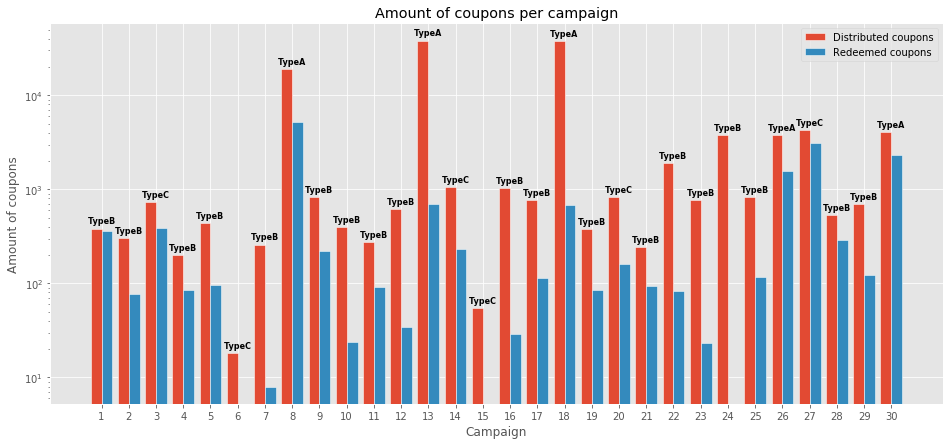

In [23]:
# set width of bar
barWidth = 0.4
 
# set height of bar
coupon_distributed = df_campaign_desc['distributed']
coupon_redeemed = df_campaign_desc['redeemed']
 
# Set position of bar on X axis
r = np.arange(len(coupon_distributed)+1)
r1 = [x - barWidth/2 for x in r[1:]]
r2 = [x + barWidth/2 for x in r[1:]]
 
# Make the plot
plt.bar(r1, coupon_distributed, width=barWidth, edgecolor='white', label='Distributed coupons')
plt.bar(r2, coupon_redeemed, width=barWidth, edgecolor='white', label='Redeemed coupons')
plt.yscale('log') #Better visualizations because very different amounts of coupon between campaign
 
# Attach a text label above each bar in *bars*, displaying the campaign type
type_c = df_campaign_desc.description.values
for i in range(len(coupon_distributed.values)):    
    plt.annotate('{}'.format(type_c[i]),
                xy=(r[i+1], coupon_distributed.values[i]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontweight = 'bold',
                fontsize = 8)
  
    
# Add title and legend
plt.title('Amount of coupons per campaign')
plt.xlabel('Campaign')
plt.xticks(df_campaign_desc.index)
plt.ylabel('Amount of coupons')
plt.legend()
plt.show()

We can see the difference between the amount of coupon distributed and redeemed differs a lot from one campaign to another. It goes from cases where it is nearly null (such as campaign 1) to extreme cases where no coupons were redeemed (such as in campaigns 6, 15 and 24). To understand what happened here, we will need to inspect more precisely each campaign and join our results with data about the products and the transactions.

## Demographics

In [24]:
marital_dict = {"A": "Married", "B": "Single", "U": "Unknown"}
household_size_dict = {"1": 1, "2": 2, "3": 3, "4": 4, "5+": 5}

In [25]:
df_demo = pd.read_csv("dunnhumby/hh_demographic.csv")
df_demo.columns = map(str.lower, df_demo.columns)

# Replace cryptic character with actual label
df_demo["married"] = df_demo["marital_status_code"].apply(
    lambda code: marital_dict[code]
)

# Create new column with numerical household size
for hh_str, hh_int in household_size_dict.items():
    df_demo["household_size_desc_numeric"] = df_demo["household_size_desc"].replace(
        hh_str, hh_int
    )
df_demo["household_size_desc_numeric"] = df_demo["household_size_desc_numeric"].astype(int)
    
df_demo.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,household_key,married,household_size_desc_numeric
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,Married,2
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,Married,2
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,Unknown,3
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,Unknown,4
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,Single,1


Let's see from which age groups we have the most people

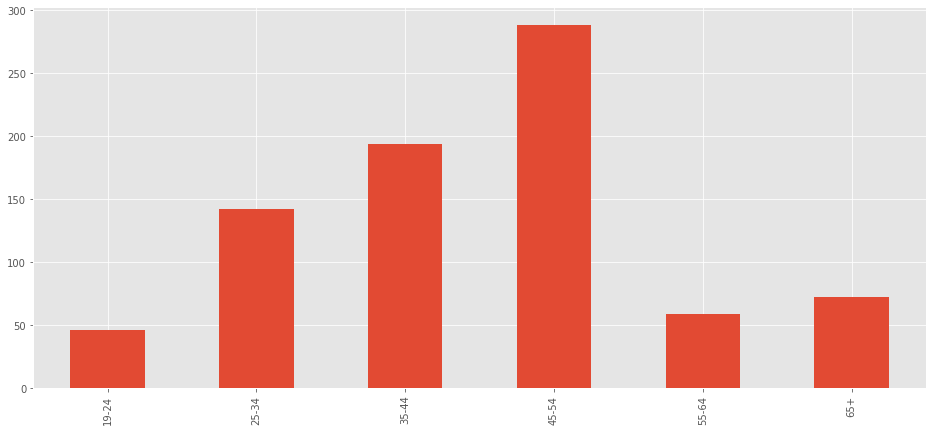

In [26]:
df_demo["age_desc"].value_counts().sort_index().plot(kind="bar")
plt.show()

## Products

In [27]:
df_products = pd.read_csv('dunnhumby/product.csv')
df_products.columns = map(str.lower, df_products.columns)
df_products.head()

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


Let's explore the product data frame and filter out anything food related. We start by looking at the column *DEPARTMENT*.

In [28]:
def filter_dataframe(df, word_list):
    filtered_df = df.copy()
    for word in word_list:
        filtered_df = filtered_df[~(filtered_df["department"].str.contains(word) | filtered_df["commodity_desc"].str.contains(word) | filtered_df["sub_commodity_desc"].str.contains(word))]
    return df[~df.index.isin(filtered_df.index)], df[df.index.isin(filtered_df.index)]

In [29]:
meat_list = ["MEAT","PORK", "BEEF", "DUCK", "CHICKEN", "POULTRY", "LAMB", "VEAL",
             "MUTTON", "TURKEY", "VENISON", "WILD BOAR", "BISON", "GOOSE", "RABBIT", "PHEASANT"]
seafood_list = ["HERRING", "SEAFOOD", "SEAFD","SUSHI", "FISH","SHRIMP","SALMON","TUNA",
                "TILAPIA","ALASKA","POLLOCK","PANGASIUS","BASA","SWAI","COD","CATFISH","CRAB","CLAMS"]
sweets_snack_list = ["ROLLS", "GUM", "PASTRY", "NUT","CRACKERS","DESSERT","SNKS","SNACK","CHIP",
                     "CANDY", "ICE", "SWEET", "CHOCOLATE","POPCORN", "CAKE", "COOKIE", "PANCAKE",
                     "BAKING", "BAKE", "PIE"]
fruits_list = ["FRUIT","APPLE", "ORANGE", "PEAR", "BANANA", "GRAPE", "BERR", "TOMATO", "LEMON", "MELON", "PEACH", "CHERR", "PINEAPPLE", "CITRUS"]
vegetable_list = ["PUMPKIN", "COLESLAW", "SPINACH", "BEAN","VEG", "POTATO", "CARROT","CORN","PEPPER", "SQUASH", "ONION", "MUSHROOM", "CUCUMBER", "CAULIFLOWER", "BROCCOLI", "OLIVE" ]
veg_animal_list = ["DAIRY","MILK","CHEESE", "YOGURT", "BUTTER", "MARGARINE", "EGG", "HONEY"]
beverage_list = ["CIDER", "BEVERAGE", "WATER", "COKE", "FANTA", "SPRITE","LIQUOR", "LEMONADE", "COCOA", "VODKA", "BEER", "WINE", "COFFEE", "DRINK", "TEA", "JUICE", "DRNKS", "JCE"]
condiment_list = ["GARLIC","SALSA","FLOUR", "DIP","OIL","SEASONING","JELLY", "JAM","SAUCE", "HERBS", "CONDIMENT", "TOPPING", "SYRUP", "DRESSING", "KETCHUP", "MAYO", "DRSNG"]
carbs_list = ["NOODLES", "PASTA", "CROUTON","RICE", "BREAD", "TOAST", "CEREAL", "OATMEAL", "DOUGH", "POTATO"]
meal_list = ["PIZZA", "RAMEN", "SANDWICH", "SALAD","SOUP","ENTREE", "DINNER", "BREAKFAST", "THAI", "ASIAN", "ITALIAN", "MEXICAN", "GERMAN", "BURRITO", "FOOD", "ORIENTAL", "DISH", "KOSHER"]

df_meat, df_rest = filter_dataframe(df_products, meat_list)
df_seafood, df_rest = filter_dataframe(df_rest, seafood_list)
df_sweets_snack, df_rest = filter_dataframe(df_rest, sweets_snack_list)
df_fruits, df_rest = filter_dataframe(df_rest, fruits_list)
df_vegetable, df_rest = filter_dataframe(df_rest, vegetable_list)
df_veg_animal, df_rest = filter_dataframe(df_rest, veg_animal_list)
df_beverage, df_rest = filter_dataframe(df_rest, beverage_list)
df_condiments, df_rest = filter_dataframe(df_rest, condiment_list)
df_carbs, df_rest = filter_dataframe(df_rest, carbs_list)
df_meals, df_rest = filter_dataframe(df_rest, meal_list)

In [30]:
#df_rest["sub_commodity_desc"].unique()

In [31]:
df_food = pd.concat([df_meat, df_seafood, df_sweets_snack, df_fruits, df_vegetable, df_veg_animal, df_beverage, df_condiments, df_carbs, df_meals])
df_food.reset_index(drop=True)

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,27860,69,GROCERY,Private,BAKING NEEDS,PIE FILLING MINCEMEAT GLAZES,21 OZ
1,27951,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
2,28267,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
3,30003,397,MEAT-PCKGD,National,FROZEN MEAT,FRZN BREADED PREPARED CHICK,9 OZ
4,31493,151,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,10 OZ
...,...,...,...,...,...,...,...
58742,18037791,69,GROCERY,Private,DOG FOODS,DRY DOG ECONOMY (COST CUTTER/F,15 LBS
58743,18105562,6235,GROCERY,National,DOG FOODS,SEMI MOIST DOG FOOD,1.5 LB
58744,18107080,6235,GROCERY,National,DOG FOODS,SEMI MOIST DOG FOOD,1 LB
58745,18118989,69,GROCERY,Private,DOG FOODS,DRY DOG ECONOMY (COST CUTTER/F,37.5 LBS


In [32]:
nfoods_no_size = df_food[df_food["curr_size_of_product"] == " "].count()["product_id"]
nfoods = df_food.count()["product_id"]

In [33]:
print("We have size info for {:.2f}% of food products".format(100 * (1 - nfoods_no_size / nfoods)))

We have size info for 85.41% of food products


## Transaction data and price analysis

In [140]:
df_transaction = pd.read_csv('dunnhumby/transaction_data.csv')
df_transaction.columns = map(str.lower, df_transaction.columns)
df_transaction.sort_values.head()

,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2595731,1598,42305362535,711,14055192,1,6.99,3228,0.00,1520,102,0.0,0.0
2592413,420,42289540827,711,1005184,1,1.50,381,-0.89,1116,102,0.0,0.0
2592406,420,42289540827,711,948368,1,2.19,381,0.00,1116,102,0.0,0.0
2592407,420,42289540827,711,960142,1,0.50,381,-0.29,1116,102,0.0,0.0
2592408,420,42289540827,711,977873,1,1.00,381,-0.19,1116,102,0.0,0.0


Now let us join the food and transaction data for more insights.

In [35]:
df_food_trans = pd.merge(df_food, df_transaction, on='product_id', how='left')

In [36]:
number_households = len(df_food_trans["household_key"].unique())
print('The dataset contains {} individual households.'.format(number_households))

The dataset contains 2501 individual households.


Let's check what percentile of the households did not buy meat and seafood products at all.

In [37]:
df_meat_seafood = df_meat.append(df_seafood).drop_duplicates()
df_meat_seafood.head()

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
45,27860,69,GROCERY,Private,BAKING NEEDS,PIE FILLING MINCEMEAT GLAZES,21 OZ
52,27951,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
71,28267,69,MEAT-PCKGD,Private,DINNER SAUSAGE,FRESH,18 OZ
123,30003,397,MEAT-PCKGD,National,FROZEN MEAT,FRZN BREADED PREPARED CHICK,9 OZ
156,31493,151,GROCERY,National,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,10 OZ


In [38]:
df_meat_seafood_trans = pd.merge(df_meat_seafood, df_transaction, on='product_id', how='left')
number_household_meat_seafood = len(df_meat_seafood_trans["household_key"].unique())
print("Number of households who did not purchased any meat or seafood: % d" %(number_households-number_household_meat_seafood))

Number of households who did not purchased any meat or seafood:  24


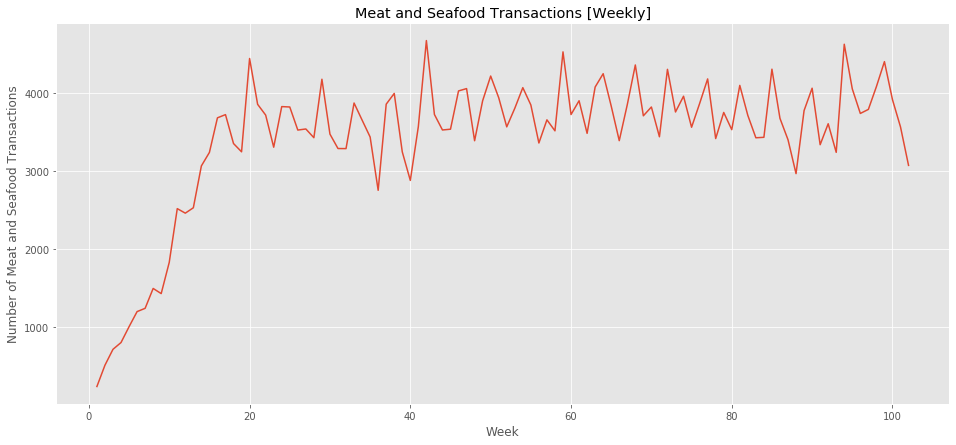

In [39]:
weekly_meat_sea = df_meat_seafood_trans.groupby("week_no").count()["product_id"]
weekly_trans = df_food_trans.groupby("week_no").count()["product_id"]
plt.plot(weekly_meat_sea)
plt.xlabel("Week")
plt.ylabel("Number of Meat and Seafood Transactions")
plt.title("Meat and Seafood Transactions [Weekly]")
plt.show()

Overall there is no upwards or downwards trend of meat and seafood transactions. But it is weird that the meat and seafood transactions rose rapidly in the first few weeks. It is likely that in the beginning not all transactions were caught. We take a look at the relation between the number of transactions and the number of meat and seafood transactions. If the rise in the beginning is only due to the fact that not all transactions were recorded, then the relation should be linear.

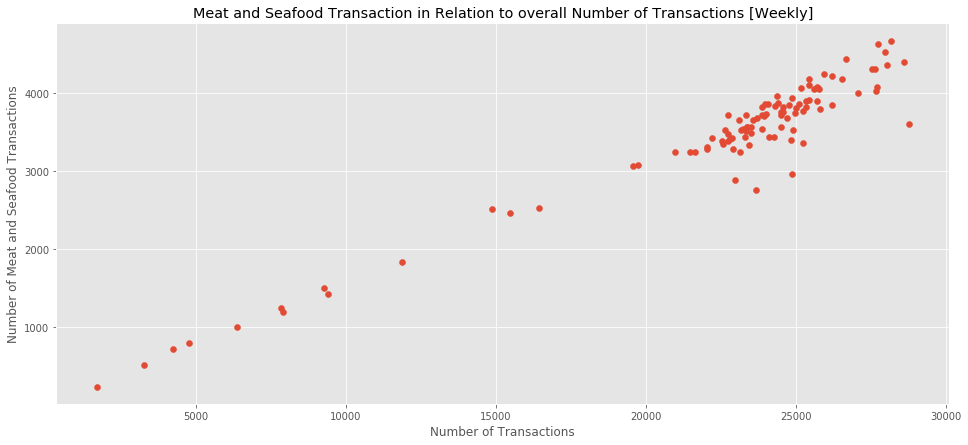

In [40]:
plt.scatter(weekly_trans, weekly_meat_sea)
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Meat and Seafood Transactions")
plt.title("Meat and Seafood Transaction in Relation to overall Number of Transactions [Weekly]")
plt.show()

The relation is indeed linear.

Next we take a look at the number of households which weekly buy meat or seafood products.

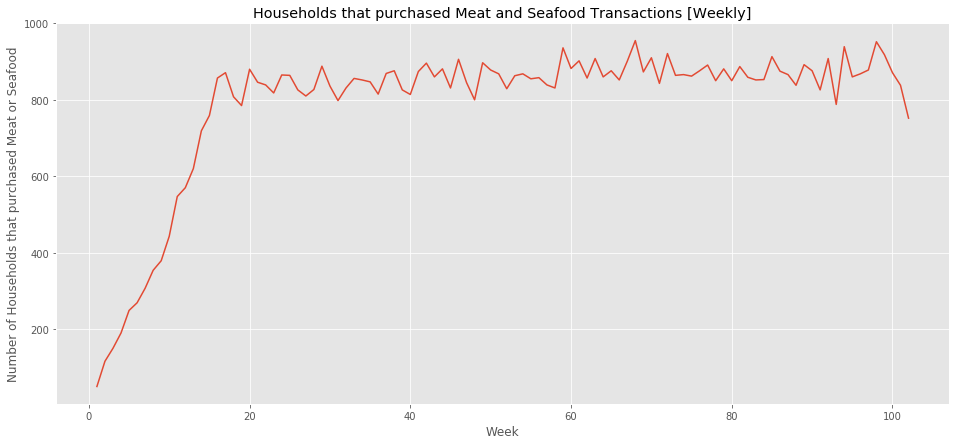

In [41]:
plt.plot(df_meat_seafood_trans.groupby("week_no")["household_key"].nunique())
plt.xlabel("Week")
plt.ylabel("Number of Households that purchased Meat or Seafood")
plt.title("Households that purchased Meat and Seafood Transactions [Weekly]")
plt.show()

The number again stays relatively stable at around 800-900. That is surprising, because the number of households which did purchase a meat product in the two years is 2475.

Let's check the number of households, which go vegetarian in a week.

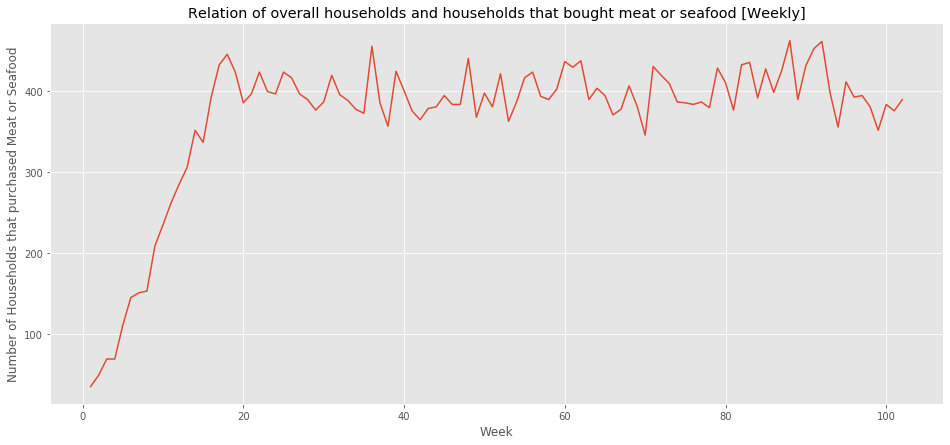

In [42]:
weekly_vege = df_food_trans.groupby("week_no")["household_key"].nunique()-df_meat_seafood_trans.groupby("week_no")["household_key"].nunique()
plt.plot(weekly_vege)
plt.xlabel("Week")
plt.ylabel("Number of Households that purchased Meat or Seafood")
plt.title("Relation of overall households and households that bought meat or seafood [Weekly]")
plt.show()

Surprisingly the number is super high considering that almost all households do not live completely vegetarian. Lets check the frequency of the meat and seafood purchases of all households.

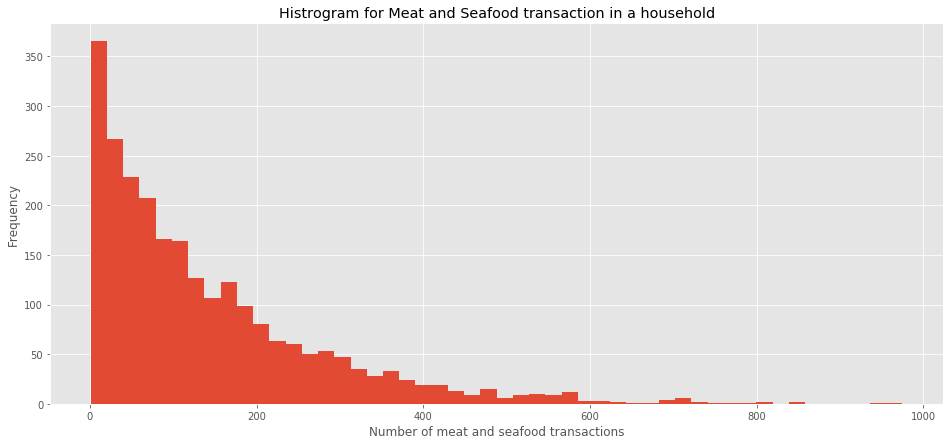

In [43]:
house_purchase = df_meat_seafood_trans.groupby("household_key").count()["product_id"]
#print(house_purchase.sort_values(ascending=False).head(10))
plt.hist(house_purchase, bins=50)
plt.xlabel("Number of meat and seafood transactions")
plt.ylabel("Frequency")
plt.title("Histrogram for Meat and Seafood transaction in a household")
plt.show()

## Categories of coupons per campaign

To do some further analysis, we will create a function *products_categories()* taking the number of a campaign and plotting the repartition of products for which coupons were offered and were redeemed based on the categories previously defined. It will also return these 2 repartitions as dictionaries with the proportion of each category as values and the categories as keys. A parameter *show_plot* will enable to show or not the plot (if only the proportions are needed). Note that the proportions for the coupons redeemed are computed as the proportion out of the total number of coupons distributed (i.e. 20% coupons redeemed in 'meat' means that 20% of the coupons distributed were redeemed for 'meat'). This is not the same as saying that 20% of the coupons redeemed were for 'meat'.

In [44]:
# Create df with all remaining products (even non-food products)
df_left_all = df_products[
    ~df_products.index.isin(
        np.concatenate(
            (
                df_meat.index,
                df_seafood.index,
                df_sweets_snack.index,
                df_fruits.index,
                df_vegetable.index,
                df_beverage.index,
                df_veg_animal.index,
                df_condiments.index,
                df_carbs.index,
                df_meals.index,
            )
        )
    )
]

In [45]:
#Categories of food (previously defined)
categories = ['Meat', 'Seafood', 'Sweet snacks', 'Fruits', 'Vegetables', 'Veg animal', 'Beverage', 'Condiments', 'Carbs', 'Meals', 'Other']
df_list = (df_meat, df_seafood, df_sweets_snack, df_fruits, df_vegetable, 
           df_veg_animal, df_beverage, df_condiments, df_carbs, df_meals, df_left_all)

def products_categories(num_camp, show_plot = False):
    proportions_dist = dict.fromkeys(categories)
    proportions_red = dict.fromkeys(categories)
    
    #Compute the number of coupons in each category
    for categ,df in enumerate(df_list):
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 coupons (for coupons distributed)
        if num_camp in df.merge(df_coupon, on = 'product_id').groupby(by = 'campaign').count().index:
            proportions_dist[categories[categ]] = df.merge(df_coupon, on = 'product_id').groupby(by = 'campaign').count().loc[num_camp][1] 
        else:
            proportions_dist[categories[categ]] = 0
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 coupons (for coupons redeemed)    
        if num_camp in df.merge(df_coupon[df_coupon.redeemed], on = 'product_id').groupby(by = 'campaign').count().index:  
            proportions_red[categories[categ]] = df.merge(df_coupon[df_coupon.redeemed],
                                                          on = 'product_id').groupby(by = 'campaign').count().loc[num_camp][1] 
        else:
            proportions_red[categories[categ]] = 0
    
    #Compute the proportion as percentage
        #Compute the total number of coupons distributed
    total = 0
    for i in proportions_dist.values(): 
           total += i 
    if total != 0:
        #Compute proportion of coupons distributed per category
        for key in proportions_dist.keys():
            proportions_dist[key] = 100*proportions_dist[key]/total
        #Compute proportion of coupons redeemed per category (proportion of the total number of coupons distributed)
            proportions_red[key] = 100*proportions_red[key]/total
    
    #Plot the repartitions of products for which coupons were offered
    if show_plot:   
        # set width of bar
        barWidth = 0.4
 
        # Set position of bar on X axis
        r = np.arange(len(proportions_dist))
        r1 = [x - barWidth/2 for x in r]
        r2 = [x + barWidth/2 for x in r]
 
        # Make the plot
        plt.bar(r1, list(proportions_dist.values()), width=barWidth, edgecolor='white', label='Distributed coupons')
        plt.bar(r2, list(proportions_red.values()), width=barWidth, edgecolor='white', label='Redeemed coupons')
        plt.xticks(range(len(proportions_dist)), list(proportions_dist.keys()))
        plt.title('Proportions of coupons per category during campaign ' + str(num_camp))
        plt.xlabel('Categories')
        plt.ylabel('Proportion of coupons [%]')
        plt.legend()
        plt.show()
    
    return (proportions_dist, proportions_red)

Let's see how the coupons distributed are spread over the different categories for campaign 4 for instance (a campaign mainly about sweet snacks).

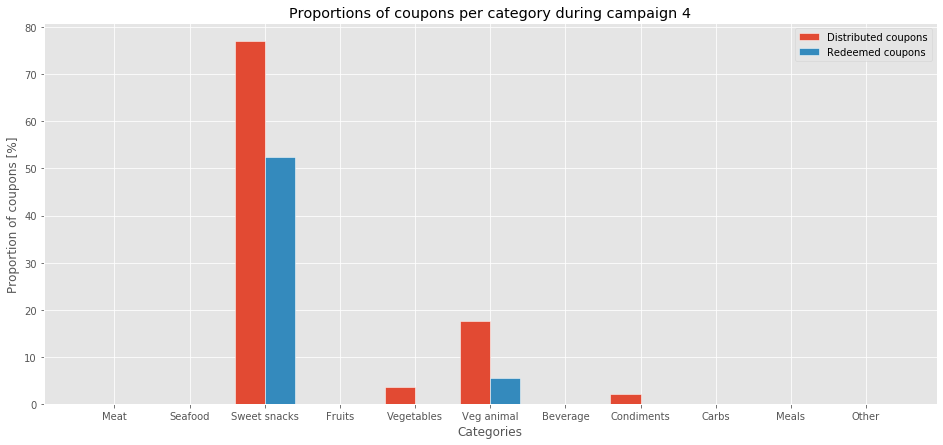

In [46]:
(prop_dist, prop_red) = products_categories(4, True)

Let's now take a more overall view, across all campaign. We will compute the proportions of coupons distributed in each category for all campaigns and plot the results in a stacked bar plot.

In [47]:
proportions_dist_overall = pd.DataFrame(columns = categories)
for i in range(30):
    proportions_dist_overall = proportions_dist_overall.append(products_categories(i+1)[0], ignore_index = True)
proportions_dist_overall.set_index(df_campaign_desc.index, inplace = True)

In [48]:
proportions_dist_overall.head()

,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other
campaign,,,,,,,,,,,
1,11.488251,0.000000,14.360313,16.971279,17.754569,39.164491,0.000000,0.261097,0.00000,0.000000,0.000000
2,15.282392,2.990033,35.880399,0.000000,29.235880,0.664452,0.000000,8.637874,0.00000,7.308970,0.000000
3,0.540541,0.000000,13.108108,0.000000,0.000000,7.162162,5.945946,29.189189,0.00000,0.000000,44.054054
4,0.000000,0.000000,77.000000,0.000000,3.500000,17.500000,0.000000,2.000000,0.00000,0.000000,0.000000
5,0.000000,0.000000,0.451467,0.000000,0.000000,0.902935,1.354402,4.966140,2.48307,63.431151,26.410835


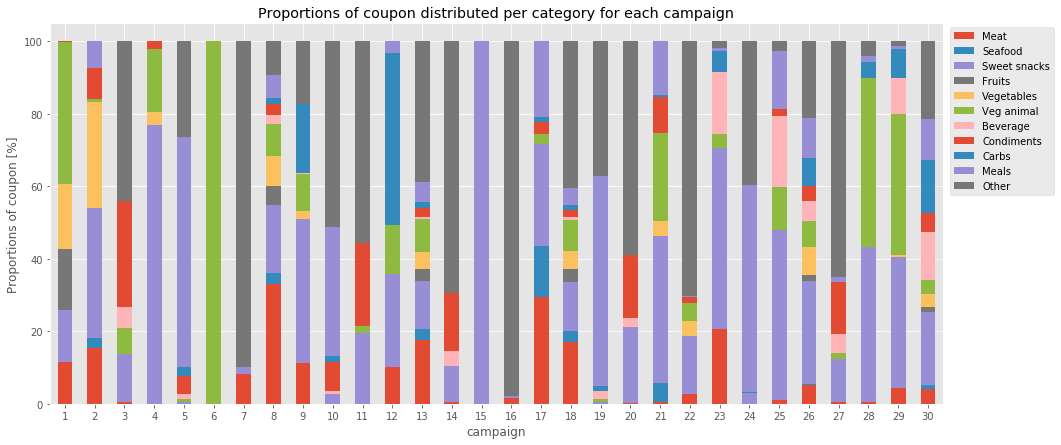

In [49]:
#colors = [[166,206,227], [31,120,180], [178,223,138], [51,160,44], [251,154,153], [227,26,28], [253,191,111], [255,127,0], [202,178,214], [106,61,154], [255,255,153]]
#colormap_ = color.ListedColormap(colors, name='from_list', N=None)
proportions_dist_overall.plot.bar(stacked = True)
plt.title('Proportions of coupon distributed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

We can do the same for the proportions of coupons redeemed per category for each campaign. Note that in this case the total will not add to 100% as not all coupons are redeemed during a campaign.

In [50]:
proportions_red_overall = pd.DataFrame(columns = categories)
for i in range(30):
    proportions_red_overall = proportions_red_overall.append(products_categories(i+1)[1], ignore_index = True)
proportions_red_overall.set_index(df_campaign_desc.index, inplace = True)

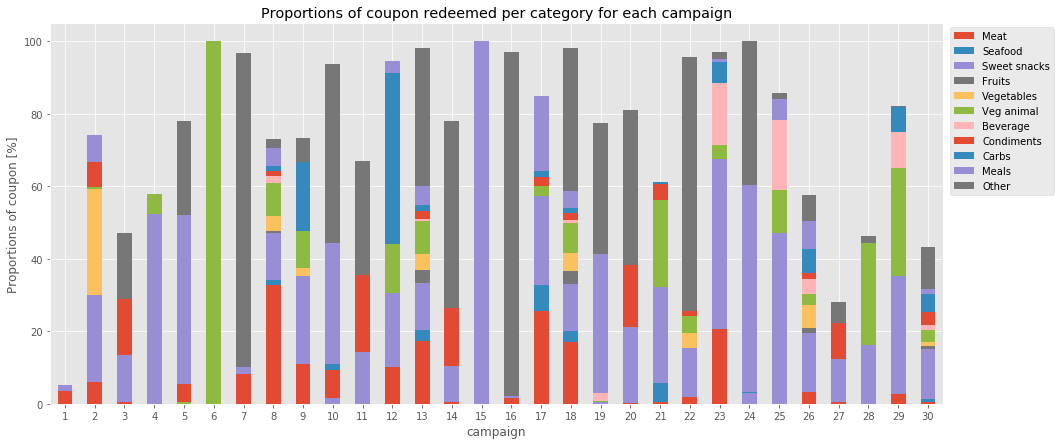

In [51]:
proportions_red_overall.plot.bar(stacked = True)
plt.title('Proportions of coupon redeemed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

## Vegetarian vs non-vegetarian

As one can see, it is still quite hard to understand what is happening. We will thus group products in fewer categories: vegetarian, non-vegetarian, unknown and other. The 'unknown' category comprises all categories were the exact list of ingredients would be needed to know if it is vegetarian or not.

In [52]:
proportions_dist_final = pd.DataFrame()
proportions_dist_final['Vegetarian'] = proportions_dist_overall['Fruits'] + proportions_dist_overall['Vegetables'] + proportions_dist_overall['Veg animal'] + proportions_dist_overall['Carbs']
proportions_dist_final['Non-vegetarian'] = proportions_dist_overall['Meat'] + proportions_dist_overall['Seafood']
proportions_dist_final['Unknown'] = proportions_dist_overall['Sweet snacks'] + proportions_dist_overall['Beverage'] + proportions_dist_overall['Condiments'] + proportions_dist_overall['Meals']
proportions_dist_final['Other'] = proportions_dist_overall['Other']

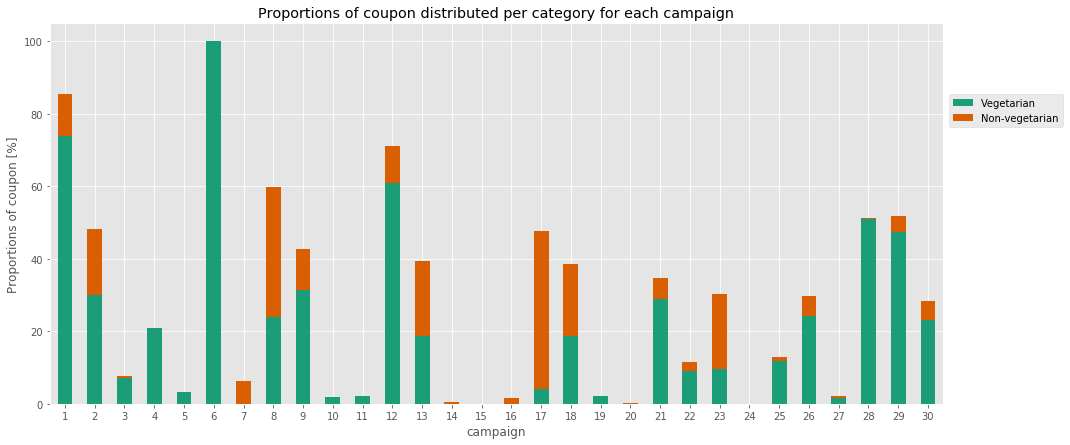

In [53]:
#Colors for 4 categories: ['#1b9e77', '#d95f02', '#7570b3', 'grey']
proportions_dist_final[["Vegetarian", "Non-vegetarian"]].plot.bar(stacked = True, color = ['#1b9e77', '#d95f02'])
plt.title('Proportions of coupon distributed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

It is now clear that there are indeed more coupons distributed for vegetarian products than for non-vegetarian ones. Note however that the proportion of coupons for the unknown category is usually the highest, meaning no absolute conclusion can be made here in the vegetarian vs non-vegetarian debate.

In [54]:
proportions_red_final = pd.DataFrame()
proportions_red_final['Vegetarian'] = proportions_red_overall['Fruits'] + proportions_red_overall['Vegetables'] + proportions_red_overall['Veg animal'] + proportions_red_overall['Carbs']
proportions_red_final['Non-vegetarian'] = proportions_red_overall['Meat'] + proportions_red_overall['Seafood']
proportions_red_final['Unknown'] = proportions_red_overall['Sweet snacks'] + proportions_red_overall['Beverage'] + proportions_red_overall['Condiments'] + proportions_red_overall['Meals']
proportions_red_final['Other'] = proportions_red_overall['Other']

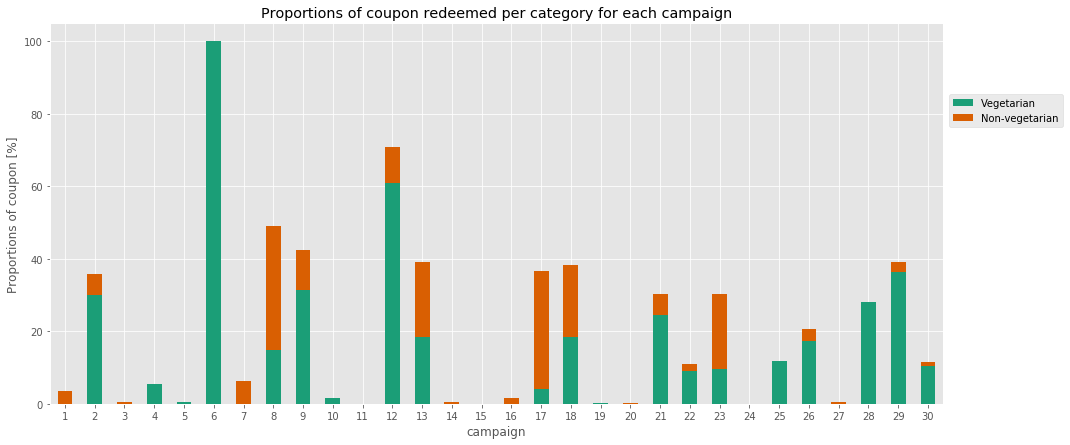

In [55]:
proportions_red_final[["Vegetarian", "Non-vegetarian"]].plot.bar(stacked = True, color = ['#1b9e77', '#d95f02'])
plt.title('Proportions of coupon redeemed per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of coupon [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

As for the proportion of distributed coupons, the proportion of coupons redeemed for vegetarian products is higher than the one for non-vegetarian products.

Let's have a more overall view at the vegetarian vs non-vegetarian proportions of coupons distributed and redeemed.

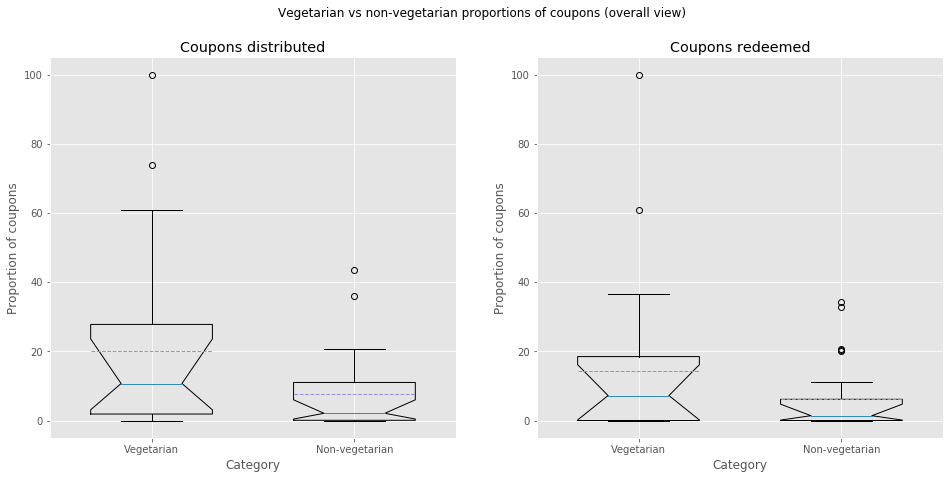

In [56]:
fig, axes = plt.subplots(1,2)

axes[0].boxplot((proportions_dist_final['Vegetarian'],proportions_dist_final['Non-vegetarian']), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showmeans = True,
                meanline = True) #Add arithmetic means as dashed line
axes[0].set_title('Coupons distributed')
axes[1].boxplot((proportions_red_final['Vegetarian'],proportions_red_final['Non-vegetarian']), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showmeans = True,
                meanline = True) #Add arithmetic means as dashed line
axes[1].set_title('Coupons redeemed')

for ax in axes:
    ax.set_xlabel('Category')
    ax.set_ylabel('Proportion of coupons')

fig.suptitle('Vegetarian vs non-vegetarian proportions of coupons (overall view)')
plt.show()

Focusing on the vegetarian vs non-vegetarian products debate, the difference over all campaigns is significant. Indeed, the notches show there is a 95% chance that the median proportions of coupons in the two categories do not overlap, both for the coupons distributed and redeemed. Note the mean proportions are also significantly different (green dashed lines). 

### Independent t-test

Let's perform an independent t-test to determine if the differences between the number of coupons distributed for vegetarian and non-vegetarian products are significant.

In [57]:
import researchpy as rp

Let's define a function *t_test()* taking two parameters, being the two lists of elements we want to compare. In this first case, it would be the proportions of coupons distributed in each campaign for vegetarian and non-vegetarian products.

This function first checks the assumptions for the t-test, ie homogeneity of variances (with Levene's test) and normal distribution of residuals (with Shapiro-Wilk's test). If those conditions are met, it proceeds to the t-test using *researchpy.ttest()* method with the parameter *equal_variances* set to True. If the variances are not equal, it tests the normality of the distributions of the two groups (with Shapiro-Wilk's test again) in order to proceeds to the Welch's test (performed by *researchpy.ttest()* with *equal_variances* set to False).

In [58]:
def t_test(categ1, categ2, visual_norm_check = False):
    test_name = ['t-test', 'Welch\'s t-test', 'Mann-Whitneyu\'s U-test']
    test_index = 0
    # == Check assumptions ==
    #Homogeneity of variances (Levene's test)
    equal_var = True
    ass_homo = stats.levene(categ1, categ2)
    if ass_homo[1] < 0.05:
        #Set equal_variances to False to proceed with Welch's t-test
        equal_var = False
        test_index = 1
        #Test assumptions for Welch's test, ie normality of the distribution of the two groups (Shapiro-Wilk's test)
        ass_welch = (stats.shapiro(categ1), stats.shapiro(categ2))
    #Normal distribution of residuals (Shapiro-Wilk's test)
    residuals = categ1 - categ2
    if visual_norm_check:
        stats.probplot(residuals, plot= plt)
        plt.title('Residuals P-P Plot') 
        plt.show()
        residuals.plot(kind= "hist", title= "Residuals histogram")
        plt.xlabel("Residuals")
        plt.show()
    ass_norm = stats.shapiro(residuals)
    norm_res = True
    if ass_norm[1] < 0.05:
        #Set norm_res to False and proceed with Mann-Whitneyu's test
        norm_res = False
        test_index = 2
    
    # == Run test == (normal t-test or Welch's test, depending on the assumptions that have been checked)
    if norm_res:
        (test_desc, test_res) = rp.ttest(categ1, categ2, equal_variances=equal_var)
    else:
        test_mann = stats.mannwhitneyu(categ1, categ2)
    
    # == Print results == 
    print('For the Levene\'s test checking the homogeneity of variances,')
    print('we have the following results: [statistic: %0.4f, p-value: %0.6f].' %(ass_homo[0], ass_homo[1]))
    if equal_var == False & norm_res == True:
        print('Since the variances are not homogeneous, we move to the Welch\'s test and check for normality of distributions of the two groups.')
        print('For the Shapiro-Wilk\'s test for the first group, we have the following results: [statistic: %0.4f, p-value: %0.6f].' %(ass_welch[0][1], ass_welch[0][1]))
        print('For the Shapiro-Wilk\'s test for the second group, we have the following results: [statistic: %0.4f, p-value: %0.6f].' %(ass_welch[1][1], ass_welch[1][1]))
    print('For the Shapiro-Wilk\'s test checking the normality of residuals,')
    print('we have the following results: [statistic: %0.4f, p-value: %0.6f].' %(ass_norm[0], ass_norm[1]))
    print('Finally, the results of the %s are the following:' %test_name[test_index])
    if norm_res:
        print('[df: %0.4f, statistic: %0.4f, p-value: %0.4f]' %(test_res.results[1], test_res.results[2], test_res.results[3]))
    else:
        print('[statistic: %0.4f, p-value: %0.4f]' %(test_mann[0], test_mann[1]))
    
    # == Return results == 
    final_results = [ass_homo, ass_norm]
    if norm_res == False:
        final_results.append(test_mann)
    else:
        if equal_var == False:
            final_results.append(ass_welch)
        final_results.append(test_desc)
        final_results.append(test_desc)
    
    return final_results

Let's apply this to the proportions of coupons distributed for vegetarian and non-vegetarian products.

In [59]:
veg = proportions_dist_final['Vegetarian']
non_veg = proportions_dist_final['Non-vegetarian']
results = t_test(veg, non_veg)

For the Levene's test checking the homogeneity of variances,
we have the following results: [statistic: 6.4303, p-value: 0.013935].
For the Shapiro-Wilk's test checking the normality of residuals,
we have the following results: [statistic: 0.8518, p-value: 0.000677].
Finally, the results of the Mann-Whitneyu's U-test are the following:
[statistic: 297.0000, p-value: 0.0117]


### How much money is actually saved during each campaign?

We have shown that campaigns tend to offer more coupons for vegetarian products compared to non-vegetarian ones (the same trend is observed for the number of coupons redeemed). However this comparisons need to also take into account the actual discount offered, as not all coupons offer the same one. It is indeed more relevant to find out how much money households save thanks to the coupons offered during the campaigns.

Let's start by inspecting the discount values of the coupons. Note we will consider positive values, meaning that if a coupon discount reads -0.4, we will consider its discount value as 0.4. We therefore apply the absolute function to the *coupon_disc* column, after having merged the coupons and the transactions dataframes.

In [60]:
discount_values = df_coupon.merge(df_transaction, on = 'product_id')[['coupon_upc', 'product_id', 'coupon_disc']].coupon_disc.map(lambda x: np.abs(x))

We have noticed some of the coupons have a null discount value. Let's find out how many.

In [61]:
print('There are %d coupons with a null discount value out of %d coupons in total.' %(discount_values[discount_values.values == 0].count(),discount_values.count()))

There are 4721043 coupons with a null discount value out of 4798932 coupons in total.


In [62]:
print('There are %0.2f%% coupons with null discount value.' %(100*discount_values[discount_values.values == 0].count()/discount_values.count()))

There are 98.38% coupons with null discount value.


Surprisingly, most of the coupons have a null discount value! Let's focus on the coupons with an actual discount value.

In [63]:
discount_values[discount_values.values > 0].describe()

count    77889.000000
mean         0.960694
std          1.020685
min          0.080000
25%          0.500000
50%          0.750000
75%          1.000000
max         55.930000
Name: coupon_disc, dtype: float64

We plot the distribution, using a log scale in the y axis since it is very right-skewed.

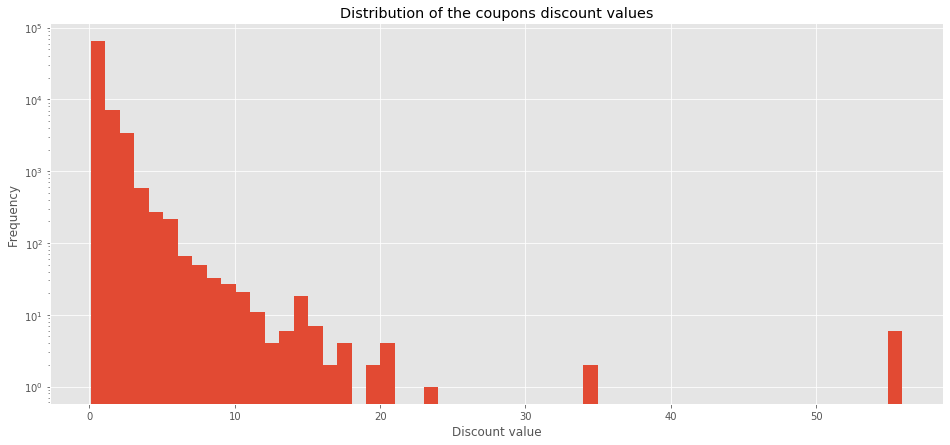

In [64]:
discount_values[discount_values.values > 0].hist(bins = 56)
plt.yscale('log')
plt.xlabel('Discount value')
plt.ylabel('Frequency')
plt.title('Distribution of the coupons discount values')
plt.show()

As expected, not all coupons offer the same discount, meaning that focusing on just the raw number of coupons offered for each category of food is not enough. The actual discount value is more relevant to find out if retailer are promoting some consumption behaviour over the others.

Let's start by merging the transactions and coupons dataframes. We only keep some columns as many of them are not useful for this analysis.

In [65]:
cols = ["product_id", "campaign", "retail_disc", "coupon_disc", "coupon_match_disc", "redeemed", "household_key"]
df_money_offered = df_transaction.merge(df_coupon, on = 'product_id')[cols]
df_money_offered['coupon_disc'] = df_money_offered['coupon_disc'].map(lambda x : np.abs(x))
df_money_saved = df_money_offered[df_money_offered.redeemed][cols]

In [66]:
df_money_offered.head()

,product_id,campaign,retail_disc,coupon_disc,coupon_match_disc,redeemed,household_key
0,1004906,8,-0.6,0.0,0.0,False,2375
1,1004906,13,-0.6,0.0,0.0,True,2375
2,1004906,18,-0.6,0.0,0.0,True,2375
3,1004906,8,-0.6,0.0,0.0,False,1929
4,1004906,13,-0.6,0.0,0.0,True,1929


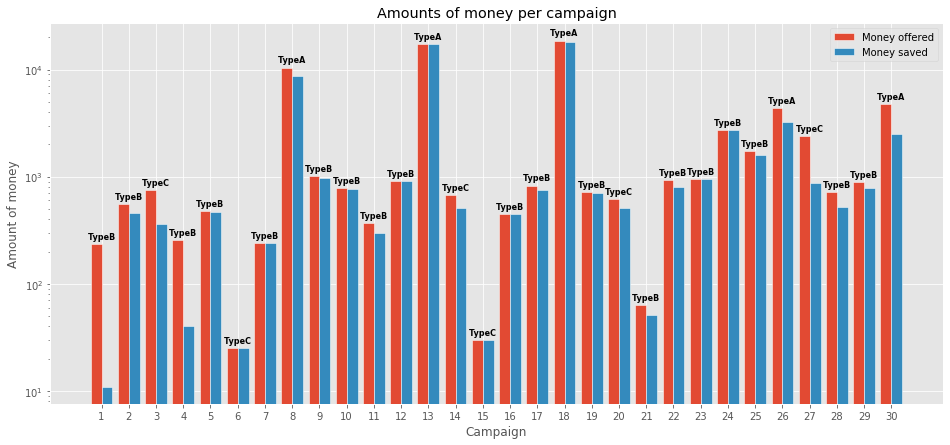

In [67]:
# set width of bar
barWidth = 0.4
 
# set height of bar
money_offered = df_money_offered.groupby(by = 'campaign')['coupon_disc'].sum()
money_saved = df_money_offered[df_money_offered.redeemed].groupby(by = 'campaign')['coupon_disc'].sum()
 
# Set position of bar on X axis
r = np.arange(len(money_offered)+1)
r1 = [x - barWidth/2 for x in r[1:]]
r2 = [x + barWidth/2 for x in r[1:]]
 
# Make the plot
plt.bar(r1, money_offered, width=barWidth, edgecolor='white', label='Money offered')
plt.bar(r2, money_saved, width=barWidth, edgecolor='white', label='Money saved')
plt.yscale('log') #Better visualizations because very different amounts of coupon between campaign
 
# Attach a text label above each bar in *bars*, displaying the campaign type
type_c = df_campaign_desc.description.values
for i in range(len(coupon_distributed.values)):    
    plt.annotate('{}'.format(type_c[i]),
                xy=(r[i+1], money_offered.values[i]),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom',
                fontweight = 'bold',
                fontsize = 8)
  
    
# Add title and legend
plt.title('Amounts of money per campaign')
plt.xlabel('Campaign')
plt.xticks(df_campaign_desc.index)
plt.ylabel('Amount of money')
plt.legend()
plt.show()

As expected, the total amounts of money offered and saved by each campaign differ a lot. This needs to be taken into account when comparing different campaigns. 

### Money offered

Let's write a function *amount_categories()* to compute the amount of money offered during a given campaign in each category of food. The *show_plot* parameter allows to choose if we want to plot the amounts of money offered and saved per category. The parameters *normalise_off* and *normalise_sav* allow to choose if we want to compute the raw amount of money or the proportion for each category. Indeed, when focusing on just one campaign the raw amount is enough, but if we want to compare different campaigns we need to look at proportions of money as not all campaigns offered the same amount of money in total.

In [68]:
def amount_categories(num_camp, show_plot = False, normalise_off = False, normalise_sav = False):
    amounts_offered = dict.fromkeys(categories) 
    amounts_saved = dict.fromkeys(categories)
    
    #Compute the amounts in each category
    total_off = 0
    total_saved = 0
    for categ,df in enumerate(df_list):
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 
        if num_camp in df_money_offered[df_money_offered.campaign == num_camp].merge(df, on = 'product_id').campaign.values:
            amounts_offered[categories[categ]] = df_money_offered[df_money_offered.campaign == num_camp].merge(df, 
                                                 on = 'product_id').coupon_disc.sum()
            total_off += amounts_offered[categories[categ]]
        else:
            amounts_offered[categories[categ]] = 0
        #Check if coupon of a category are given for a specific campaign, otherwise simply puts 0 
        if num_camp in df_money_saved[df_money_offered.campaign == num_camp].merge(df, on = 'product_id').campaign.values:
            amounts_saved[categories[categ]] = df_money_saved[df_money_offered.campaign == num_camp].merge(df, 
                                                 on = 'product_id').coupon_disc.sum()
            total_saved += amounts_saved[categories[categ]]
        else:
            amounts_saved[categories[categ]] = 0

    #Normalisation
    if normalise_off and total_off != 0:
        for categ in categories:
            amounts_offered[categ] = 100*amounts_offered[categ]/total_off
    if normalise_sav and total_saved != 0:
        for categ in categories:
            amounts_saved[categ] = 100*amounts_saved[categ]/total_saved

    #Plot the amount of money in each category
    if show_plot:   
        # set width of bar
        barWidth = 0.4
 
        # Set position of bar on X axis
        r = np.arange(len(amounts_offered))
        r1 = [x - barWidth/2 for x in r]
        r2 = [x + barWidth/2 for x in r]
 
        # Make the plot
        plt.bar(r1, list(amounts_offered.values()), width=barWidth, edgecolor='white', label='Amount of money offered')
        plt.bar(r2, list(amounts_saved.values()), width=barWidth, edgecolor='white', label='Amount of money saved')
        plt.xticks(range(len(amounts_offered)), list(amounts_offered.keys()))
        if normalise_off:
            plt.title('Proportions of money offered per category during campaign ' + str(num_camp))
            plt.ylabel('Proportion of money offered [%]')
        else:
            plt.title('Amounts of money offered per category during campaign ' + str(num_camp))
            plt.ylabel('Amount of money offered')            
        plt.xlabel('Categories')
        plt.legend()
        plt.show()
    
    return (amounts_offered, amounts_saved)

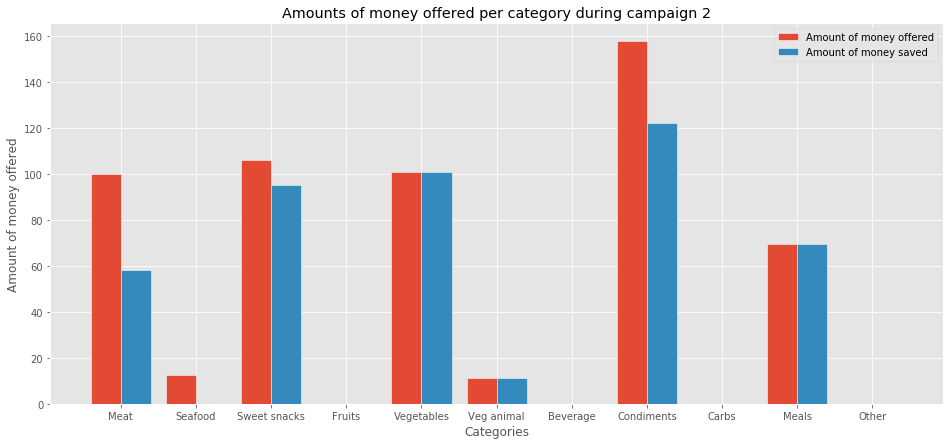

In [69]:
amounts_test = amount_categories(2, True, False, False)

Let's see the total discount obtained with coupons for each campaign (looking at each category).

In [70]:
df_veg = df_fruits.append(df_vegetable).append(df_veg_animal).append(df_carbs)
df_non_veg = df_meat.append(df_seafood)

In [71]:
df_money_offered_categ = pd.DataFrame()
df_money_offered_categ['Total'] = df_money_offered.groupby(by = 'campaign')['coupon_disc'].sum()
for categ,df in enumerate(df_list):
    df_money_offered_categ[categories[categ]] = df_money_offered.merge(df, on = 'product_id').groupby(by = 'campaign')['coupon_disc'].sum()
df_money_offered_categ['Vegetarian'] = df_money_offered.merge(df_veg, on = 'product_id')[cols].groupby(by = 'campaign')['coupon_disc'].sum()
df_money_offered_categ['Non-vegetarian'] = df_money_offered.merge(df_non_veg, on = 'product_id')[cols].groupby(by = 'campaign')['coupon_disc'].sum()
df_money_offered_categ.fillna(0, inplace = True)

In [72]:
df_money_offered_categ.head()

,Total,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other,Vegetarian,Non-vegetarian
campaign,,,,,,,,,,,,,,
1,237.03,15.50,0.00,32.13,7.55,18.8,163.05,0.0,0.00,0.0,0.0,0.00,189.40,15.50
2,557.71,100.05,12.55,105.96,0.00,100.9,11.10,0.0,157.65,0.0,69.5,0.00,112.00,112.60
3,753.02,55.93,0.00,35.50,0.00,0.0,43.80,21.6,251.84,0.0,0.0,344.35,43.80,55.93
4,254.00,0.00,0.00,201.55,0.00,10.0,42.45,0.0,0.00,0.0,0.0,0.00,52.45,0.00
5,473.64,0.00,0.00,0.00,0.00,0.0,3.00,5.0,4.50,0.0,133.0,328.14,3.00,0.00


In [73]:
df_money_offered_categ.describe()

,Total,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other,Vegetarian,Non-vegetarian
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2494.250333,259.804667,36.333333,470.750667,2.627000,81.077333,258.002000,159.843333,152.143333,177.822000,272.785667,623.061000,519.528333,296.138000
std,4688.119049,677.188293,99.369509,929.873937,7.135614,191.941314,591.840445,412.691929,230.092257,345.559464,547.814499,1281.672031,1035.068418,774.758287
min,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,456.442500,0.000000,0.000000,20.782500,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,4.212500,0.000000
50%,766.165000,18.250000,0.000000,155.550000,0.000000,0.000000,41.025000,3.750000,6.650000,0.000000,17.545000,213.420000,89.725000,18.250000
75%,1555.952500,98.972500,0.000000,352.660000,0.000000,16.600000,169.372500,93.832500,180.777500,78.767500,149.335000,523.300000,370.107500,114.130000
max,18638.760000,2447.000000,375.550000,3427.230000,34.820000,656.740000,2261.000000,2003.100000,810.890000,1315.390000,2069.540000,5199.520000,3796.170000,2822.550000


We normalise the amounts of money offered to better compare two campaigns (as we have seen that the total amount of money offered differs a lot). We also add the amounts normalised for the vegetarian and non-vegetarian categories. Note we directly compute the amount of money saved that will be used later (better efficiency to compute both at once). 

In [74]:
df_money_offered_categ_normalized = pd.DataFrame(columns = categories)
df_money_saved_categ_normalized = pd.DataFrame(columns = categories)
for i in range(30):
    temp = amount_categories(i+1, False, True, True)
    df_money_offered_categ_normalized = df_money_offered_categ_normalized.append(temp[0], ignore_index = True)
    df_money_saved_categ_normalized = df_money_saved_categ_normalized.append(temp[1], ignore_index = True)
df_money_offered_categ_normalized.set_index(df_campaign_desc.index, inplace = True)
df_money_saved_categ_normalized.set_index(df_campaign_desc.index, inplace = True)

df_money_offered_categ_normalized['Vegetarian'] = df_money_offered_categ_normalized['Fruits'] + df_money_offered_categ_normalized['Vegetables'] + df_money_offered_categ_normalized['Carbs'] + df_money_offered_categ_normalized['Veg animal']
df_money_offered_categ_normalized['Non-vegetarian'] = df_money_offered_categ_normalized['Meat'] + df_money_offered_categ_normalized['Seafood']
df_money_saved_categ_normalized['Vegetarian'] = df_money_saved_categ_normalized['Fruits'] + df_money_saved_categ_normalized['Vegetables'] + df_money_saved_categ_normalized['Carbs'] + df_money_saved_categ_normalized['Veg animal']
df_money_saved_categ_normalized['Non-vegetarian'] = df_money_saved_categ_normalized['Meat'] + df_money_saved_categ_normalized['Seafood']

We can plot our results in a barplot (first for each category, then for veg vs non-veg).

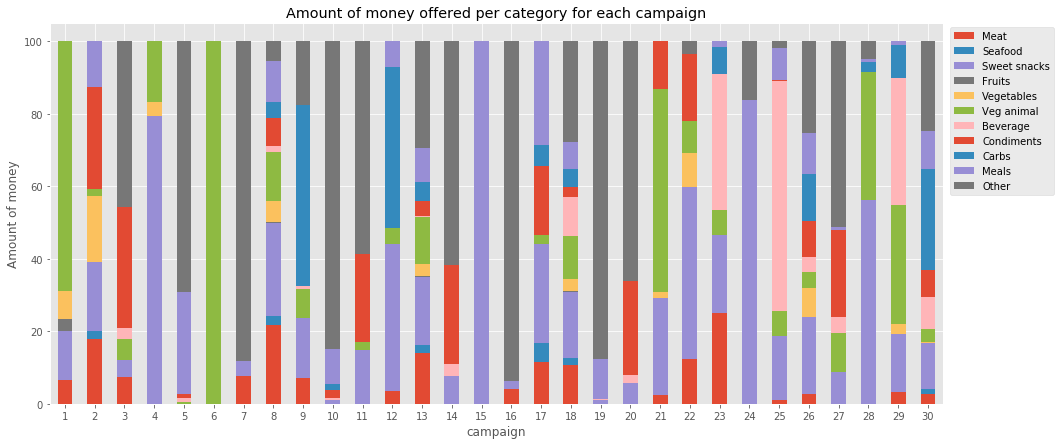

In [75]:
df_money_offered_categ_normalized[categories].plot.bar(stacked = True)
plt.title('Amount of money offered per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Amount of money')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

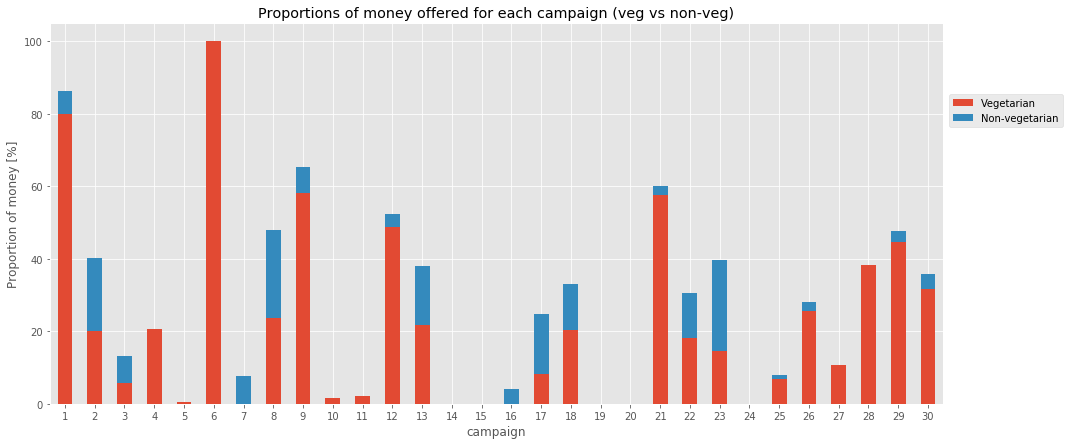

In [76]:
df_money_offered_categ_normalized[["Vegetarian", "Non-vegetarian"]].plot.bar(stacked = True)
plt.title('Proportions of money offered for each campaign (veg vs non-veg)')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportion of money [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

We see that the proportion of money offered for vegetarian products seem higher than for non-vegetarian products in the majority of campaigns.

Let's summarise those results for the vegetarian and non-vegetarian categories in a boxplot. Note we have decided to not show outliers as they would squeeze too much the boxes. We display both the raw amounts of money and the proportions of money.

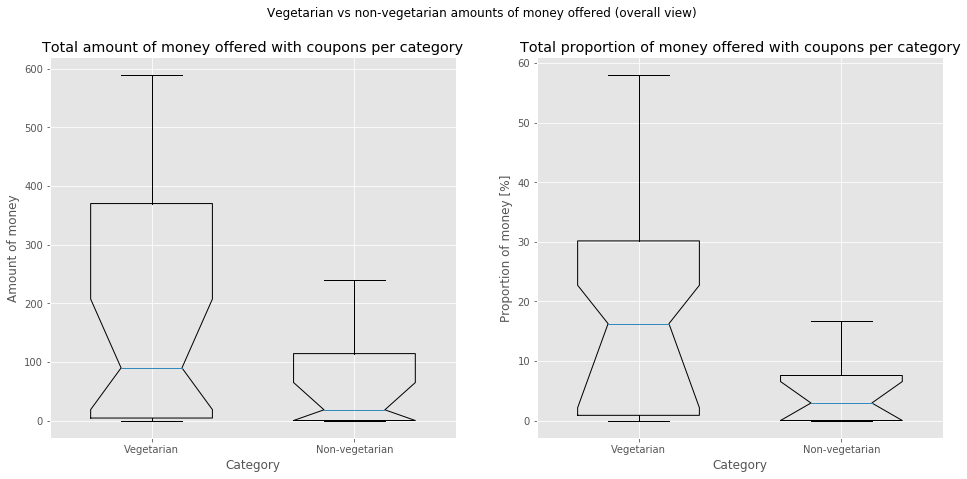

In [77]:
fig, axes = plt.subplots(1,2)

axes[0].boxplot((df_money_offered_categ["Vegetarian"],df_money_offered_categ["Non-vegetarian"]), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showfliers = False) 
axes[0].set_ylabel('Amount of money')
axes[0].set_title('Total amount of money offered with coupons per category')

axes[1].boxplot((df_money_offered_categ_normalized["Vegetarian"],df_money_offered_categ_normalized["Non-vegetarian"]), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showfliers = False)
axes[1].set_ylabel('Proportion of money [%]')
axes[1].set_title('Total proportion of money offered with coupons per category')

for ax in axes:
    ax.set_xlabel('Category')

fig.suptitle('Vegetarian vs non-vegetarian amounts of money offered (overall view)')
plt.show()

In [78]:
results = t_test(df_money_offered_categ["Vegetarian"],df_money_offered_categ["Non-vegetarian"])

For the Levene's test checking the homogeneity of variances,
we have the following results: [statistic: 0.8251, p-value: 0.367440].
For the Shapiro-Wilk's test checking the normality of residuals,
we have the following results: [statistic: 0.6849, p-value: 0.000001].
Finally, the results of the Mann-Whitneyu's U-test are the following:
[statistic: 332.5000, p-value: 0.0398]


### Money saved

Let's do the same for the coupons redeemed, thus getting the actual amount of money saved by customers.

In [79]:
df_money_saved_categ = pd.DataFrame()
df_money_saved_categ['Total'] = df_money_saved.groupby(by = 'campaign')['coupon_disc'].sum()
for categ,df in enumerate(df_list):
    df_money_saved_categ[categories[categ]] = df_money_saved.merge(df, on = 'product_id').groupby(by = 'campaign')['coupon_disc'].sum()
df_money_saved_categ['Vegetarian'] = df_money_saved.merge(df_veg, on = 'product_id')[cols].groupby(by = 'campaign')['coupon_disc'].sum()
df_money_saved_categ['Non-vegetarian'] = df_money_saved.merge(df_non_veg, on = 'product_id')[cols].groupby(by = 'campaign')['coupon_disc'].sum()
df_money_saved_categ.fillna(0, inplace = True)

In [80]:
df_money_saved_categ.describe()

,Total,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other,Vegetarian,Non-vegetarian
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2188.834000,248.029667,30.868333,414.334333,1.793000,76.905667,231.858333,138.308000,126.208667,149.919667,243.243667,527.364667,460.476667,278.898000
std,4528.722509,673.113279,91.969757,852.886434,6.702387,187.185474,591.140404,411.925386,201.838209,281.885046,531.904747,1247.493906,1009.073439,758.677068
min,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,384.957500,0.000000,0.000000,8.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,729.520000,3.770000,0.000000,116.975000,0.000000,0.000000,22.450000,0.000000,3.000000,0.000000,12.545000,185.515000,33.125000,6.275000
75%,960.800000,69.750000,0.000000,341.935000,0.000000,0.000000,107.550000,25.417500,157.032500,69.150000,94.295000,405.497500,274.205000,72.597500
max,18218.740000,2447.000000,375.550000,3298.090000,34.820000,656.740000,2259.100000,2002.100000,701.490000,947.770000,2069.540000,5061.400000,3750.790000,2822.550000


We can plot our results in a barplot (first for each category, then for veg vs non-veg).

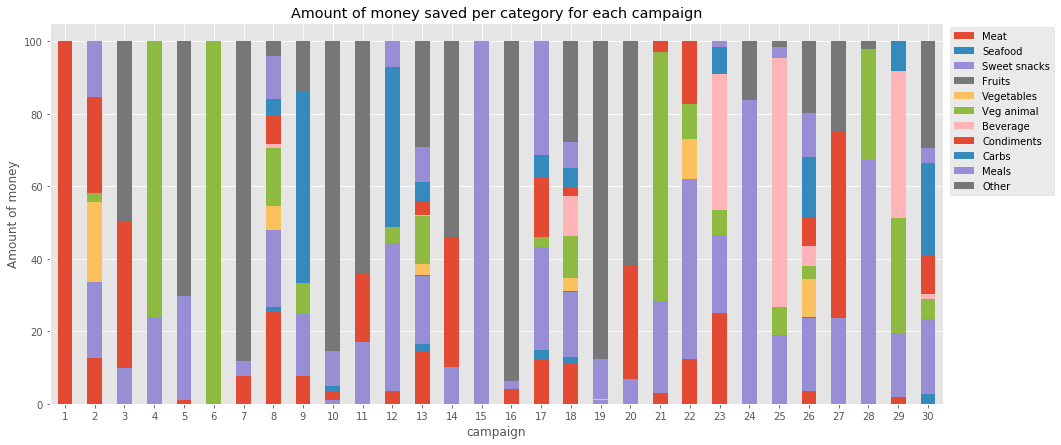

In [81]:
df_money_saved_categ_normalized[categories].plot.bar(stacked = True)
plt.title('Amount of money saved per category for each campaign')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Amount of money')
plt.legend(loc = 5, bbox_to_anchor = (1.13,0.77))
plt.show()

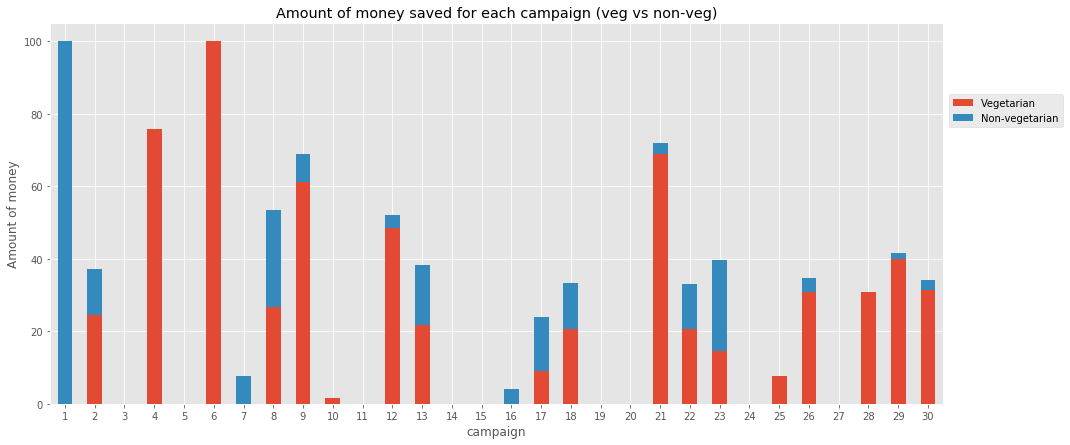

In [82]:
df_money_saved_categ_normalized[["Vegetarian", "Non-vegetarian"]].plot.bar(stacked = True)
plt.title('Amount of money saved for each campaign (veg vs non-veg)')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Amount of money')
plt.legend(loc = 5, bbox_to_anchor = (1.14,0.77))
plt.show()

Let's summarise those results for the vegetarian and non-vegetarian categories in a boxplot. Here again, we have decided to not show outliers as they would squeeze too much the boxes.

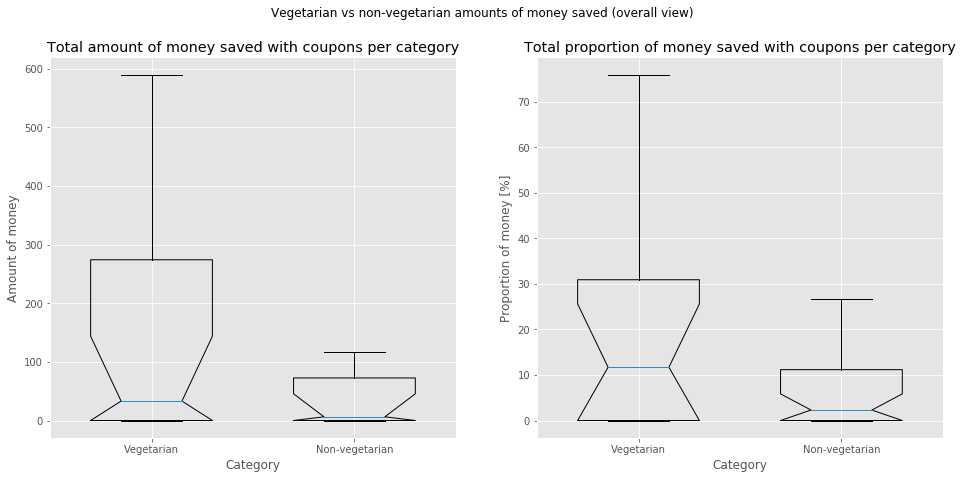

In [83]:
fig, axes = plt.subplots(1,2)

axes[0].boxplot((df_money_saved_categ["Vegetarian"],df_money_saved_categ["Non-vegetarian"]), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showfliers = False) 
axes[0].set_ylabel('Amount of money')
axes[0].set_title('Total amount of money saved with coupons per category')

axes[1].boxplot((df_money_saved_categ_normalized["Vegetarian"],df_money_saved_categ_normalized["Non-vegetarian"]), 
                labels = ('Vegetarian', 'Non-vegetarian'),
                notch = True, bootstrap = 1000, #Add CI for median, computed through bootstrap with n = 1000
                widths = 0.6,
                showfliers = False)
axes[1].set_ylabel('Proportion of money [%]')
axes[1].set_title('Total proportion of money saved with coupons per category')

for ax in axes:
    ax.set_xlabel('Category')

fig.suptitle('Vegetarian vs non-vegetarian amounts of money saved (overall view)')
plt.show()

In [84]:
results = t_test(df_money_saved_categ["Vegetarian"],df_money_saved_categ["Non-vegetarian"])

For the Levene's test checking the homogeneity of variances,
we have the following results: [statistic: 0.6019, p-value: 0.441022].
For the Shapiro-Wilk's test checking the normality of residuals,
we have the following results: [statistic: 0.6544, p-value: 0.000000].
Finally, the results of the Mann-Whitneyu's U-test are the following:
[statistic: 371.0000, p-value: 0.1130]


### Before & after a campaign

Let's compare consumption behaviours before and after each campaign.

In [120]:
cols = ["household_key", "basket_id", "product_id", "quantity", "sales_value", "retail_disc", "coupon_disc", "coupon_match_disc"]
df_test = df_transaction.merge(df_meat, on = 'product_id')
df_test.sort_values(by = 'day', ascending = False).head()

,household_key,basket_id,day,product_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
323659,2125,42291245957,711,14079391,1,2.50,795,-1.29,1427,102,0.0,0.0,1275,MEAT-PCKGD,National,LUNCHMEAT,HAM,10 OZ
237064,1146,42289881473,711,6514227,1,2.50,304,-0.79,1456,102,0.0,0.0,1598,MEAT-PCKGD,National,FROZEN MEAT,CORN DOGS,9.87 OZ
170301,968,42289907870,711,823704,2,5.00,402,-2.58,2020,102,0.0,0.0,2082,MEAT-PCKGD,National,BREAKFAST SAUSAGE/SANDWICHES,ROLLS - PORK,16 OZ
305866,1483,42289808190,711,12984576,1,9.99,370,-3.75,1618,102,0.0,0.0,4426,MEAT,National,BEEF,ANGUS BEEF,
305797,239,42289490562,711,13003092,1,3.88,388,-1.25,1035,102,0.0,0.0,2866,MEAT,National,BEEF,RIBS,


To do so, we design a function taking the id of a campaign (*num_camp*), the *df* and *categ* of the category of food we are interested in and *show_plot* to specify if we want to plot the results. It computes the sales before and after the given campaign in the given category, then gets the means and respective 95% CI. Finally, it tests the null hypothesis H0 that the sales before and after the campaign have the same mean with the Mann-Whiteneyu's non-parametric test, at the $\alpha$ level given (0.05 by default). Note the sales values are normalized per day since the number of days before and after a given campaign is not always the same (especially for the first and last campaigns) and with the total sales values (to get the proportion of sales values in the given category). If there are not at least 10 days before or after, all results are mapped to -1 (impossible value to get otherwise) to easily remove them later and the function outputs that the results are not significant (to identify which campaigns follow this behaviour).

Note we have decided to split this function in smaller ones, defining *get_sales()* to compute the normalized sales before and after, *compute_test()* to compute the corresponding means and 95% (by default) confidence interval for the means and finally *mann_test()* to perform the Mann-Whitneyu's test.

In [303]:
def get_sales(num_camp, df):
    #Obtain starting and ending day of the given campaign (+duration to normalise sales values per day)
    start_day = df_campaign_desc.loc[num_camp].start_day
    end_day = df_campaign_desc.loc[num_camp].end_day
    before = start_day - 1  #Number of days before the campaign
    after = 711 - end_day  #Number of days after the campaign  

    #Compute the sales before and after the campaign for a specific category
    significant = True
    if before > 10:
        sales_before = df_transaction[df_transaction.day < start_day].merge(df, 
                                                    on = 'product_id').groupby(by = 'household_key').sales_value.sum()
        tot_sales_before = df_transaction[df_transaction.day < start_day].groupby(by = 'household_key').sales_value.sum()
        sales_before.divide(tot_sales_before[tot_sales_before.index.isin(sales_before.index)].values)
        sales_before = sales_before.map(lambda x: 100*x/before)
    else:
        sales_before = -1
        significant = False
    if after > 10:
        sales_after = df_transaction[df_transaction.day > end_day].merge(df, 
                                                    on = 'product_id').groupby(by = 'household_key').sales_value.sum()
        tot_sales_after = df_transaction[df_transaction.day > end_day].groupby(by = 'household_key').sales_value.sum()
        sales_after.divide(tot_sales_after[tot_sales_after.index.isin(sales_after.index)].values)
        sales_after = sales_after.map(lambda x: 100*x/after)
    else:
        sales_after = -1
        significant = False
        
    return (sales_before, sales_after, significant)
    

In [304]:
def compute_stats(data, confidence = 0.95):

    n = len(data)
    m = scipy.mean(data)
    std_err = stats.sem(data)
    h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    
    return (m, h)

In [305]:
def mann_test(data1, data2, show_test, alpha):
    results = stats.mannwhitneyu(data1, data2)
    if show_test:
        print("Results of the Mann-Whitneyu\'s test: statistic U: %0.3f, p-value: %f" %(results[0], results[1]))  
        if results[1] < alpha:
            print("The p-value is smaller than the \u03B1 level given: the null hypothesis can be rejected.")
        else:
            print("The p-value is bigger than the \u03B1 level given: the groups tested do not violate the null hypothesis.")
    
    return results

In [306]:
def before_after_sales(num_camp, df, categ = "", show_plot = False, show_test = False, alpha = 0.05):
    #Compute the sales before and after the campaign for a specific category
    (sales_before, sales_after, significant) = get_sales(num_camp, df)
    
    #Compute the mean and 95% CI of the mean for the sales
    if significant:
        sales_stats = (compute_stats(sales_before), compute_stats(sales_after))
        means = [sales_stats[0][0], sales_stats[1][0]]
        err = [sales_stats[0][1], sales_stats[1][1]]
    else:
        means = [-1, -1]
        err = [-1, -1]
    
    #Plot the mean sales values before and after the campaign
    if significant:
        if show_plot:
            barWidth = 0.4
            plt.bar(x = np.arange(2), height = means, width = barWidth, yerr = err)
            plt.xticks(np.arange(2), ["Before", "After"], fontsize = 16)
            plt.yticks(fontsize = 16)
            plt.title("Proportion of %s sales values per day before and after campaign %d" %(categ, num_camp), fontsize = 18)
            plt.ylabel("Proportion of %s sales values per day [%%]" %categ, fontsize = 16)
            plt.show()
            
    #Specify if the results are not significant due to low number of days before or after the campaign
    if significant == False:
        print("The results for campaign %d are not significant because the number of days before or after the campaign is too low." %num_camp)
        
    #t-test
    if significant:
        results = mann_test(sales_before, sales_after, show_test, alpha)
    else:
        results = (-1, -1)
                
    return (means, err, results)

Let's test this function with campaign 6.

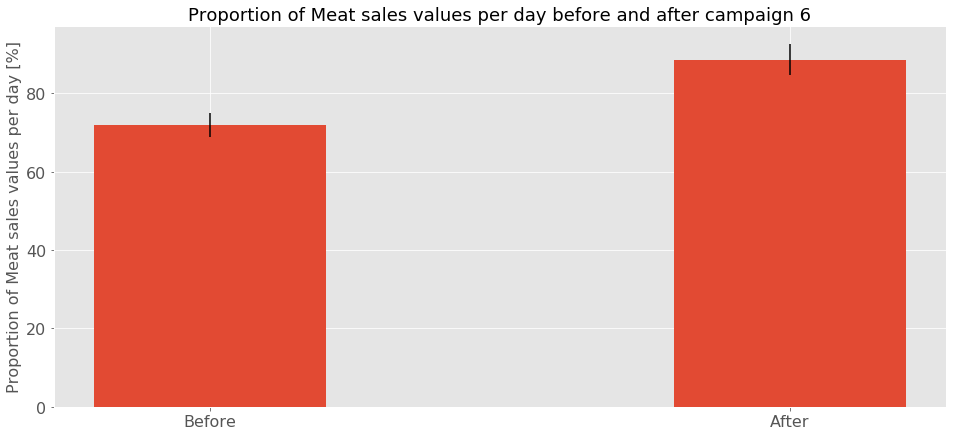

Results of the Mann-Whitneyu's test: statistic U: 2640963.000, p-value: 0.000001
The p-value is smaller than the α level given: the null hypothesis can be rejected.


In [307]:
(means, err, results) = before_after_sales(6, df_meat, "Meat", True, True)

We observe that there is an increase in the proportion of sales values of non-vegetarian products after campaign 6. The difference is significant, due to the results of the Mann-Whiteneyu's test (U = 2683247.000, p-value << 0.05). This is quite surprising because campaign 6 was only about vegetarian products and therefore we expected that it would have encouraged people to buy less non-vegetarian products!

We can now run this function for each campaign. We will do it to examine the meat consumption before and after each campaign. We store in a dataframe the means with the errors (for a confidence level of 95%) as well as the results of the Mann-Whitneyu's test for each campaign.

In [308]:
before_after_meat_sales = pd.DataFrame(columns = ["Campaign", "Mean before", "Mean after", "Error before", "Error after", "U stat", "p-value"])
for i in range(30):
    (means, err, results) = before_after_sales(i+1, df_meat)
    before_after_meat_sales = before_after_meat_sales.append({"Campaign": i+1,
                                                              "Mean before": means[0],
                                                              "Mean after": means[1],
                                                              "Error before": err[0],
                                                              "Error after": err[1],
                                                              "U stat": results[0],
                                                              "p-value": results[1]}, 
                                                              ignore_index = True)

The results for campaign 15 are not significant because the number of days before or after the campaign is too low.
The results for campaign 24 are not significant because the number of days before or after the campaign is too low.


For some campaigns, there are enough days before or after for the results to be significant. We simply remove them.

In [292]:
before_after_meat_sales = before_after_meat_sales[before_after_meat_sales['Mean before'] > 0]

In [295]:
before_after_meat_sales.head()

,Campaign,Mean before,Mean after,Error before,Error after,U stat,p-value
0,1.0,16.930254,20.934832,0.685756,0.868343,2627622.0,2.872339e-07
1,2.0,17.004242,20.934832,0.689554,0.868343,2634567.0,4.754752e-07
2,3.0,17.060911,21.047676,0.692143,0.873751,2618165.0,3.073673e-07
3,4.0,17.133072,21.116510,0.693870,0.877143,2633718.0,3.415537e-07
4,5.0,17.156796,21.047878,0.695617,0.873615,2636645.0,3.267404e-07


Let's plot our results to get the general picture.

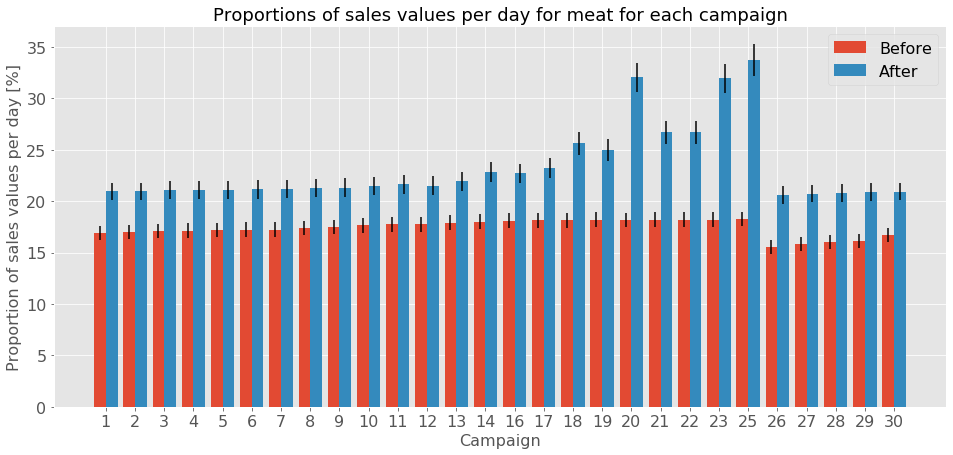

In [296]:
barWidth = 0.4
r = np.arange(len(before_after_meat_sales))
r1 = [x - barWidth/2 for x in r]
r2 = [x + barWidth/2 for x in r]

err = before_after_meat_sales[["Error before", "Error after"]].values
plt.bar(x = r1, height = before_after_meat_sales['Mean before'], width = barWidth,
                yerr = before_after_meat_sales['Error before'], label = 'Before')
plt.bar(x = r2, height = before_after_meat_sales['Mean after'], width = barWidth, 
                yerr = before_after_meat_sales['Error after'], label = 'After')
#before_after_meat_sales[["Mean before", "Mean after"]].plot.bar()
plt.xticks(np.arange(len(before_after_meat_sales)), before_after_meat_sales.Campaign.map(lambda x: int(x)).values, rotation = 'horizontal', fontsize = 16)
plt.xlabel('Campaign', fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylabel('Proportion of sales values per day [%]', fontsize = 16)
plt.title('Proportions of sales values per day for meat for each campaign', fontsize = 18)
plt.legend(fontsize = 16)
plt.show()

### Per household

In [88]:
money_per_household_per_category = pd.DataFrame()
money_per_household_per_category['Total'] = df_transaction.groupby(by = 'household_key').coupon_disc.sum() 
for (categ,df) in enumerate(df_list):
    money_per_household_per_category[categories[categ]] = df_transaction.merge(df, on = 'product_id').groupby(by = 'household_key').coupon_disc.sum()
money_per_household_per_category.fillna(0, inplace = True)
money_per_household_per_category = money_per_household_per_category.apply(lambda x: np.abs(x))

Let's add the money saved for vegetarian and non-vegetarian products.

In [89]:
money_per_household_per_category['Vegetarian'] = money_per_household_per_category['Fruits'] + money_per_household_per_category['Vegetables'] + money_per_household_per_category['Veg animal'] + money_per_household_per_category['Carbs']
money_per_household_per_category['Non-vegetarian'] = money_per_household_per_category['Meat'] + money_per_household_per_category['Seafood']

We can have a look at the amounts of money saved per category of food for a given household.

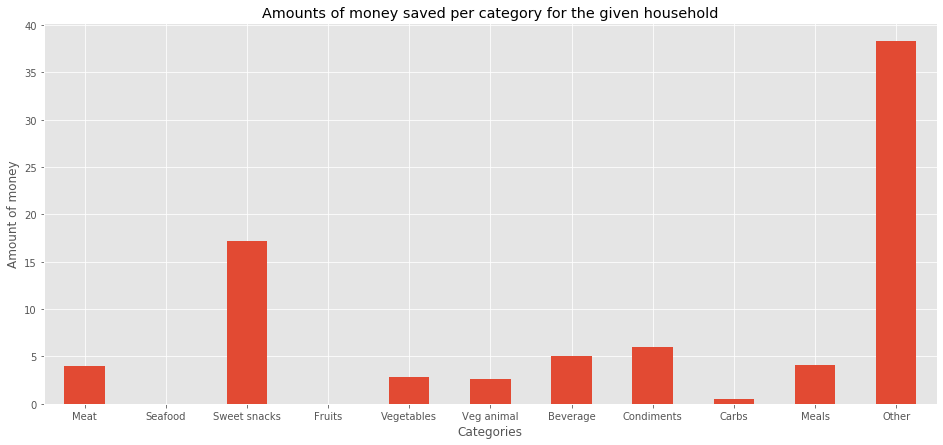

In [90]:
money_per_household_per_category[categories].iloc[0].plot.bar()
plt.xticks(rotation = 'horizontal')
plt.xlabel('Categories')
plt.ylabel('Amount of money')
plt.title('Amounts of money saved per category for the given household')
plt.show()

In [91]:
money_per_household_per_category.sort_values(by = 'Total', ascending = False).head()

,Total,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other,Vegetarian,Non-vegetarian
household_key,,,,,,,,,,,,,,
574,509.83,37.09,0.00,51.44,1.10,13.25,44.20,17.00,30.00,5.00,76.20,234.55,63.55,37.09
1166,462.59,24.44,0.00,101.49,0.75,5.70,16.30,3.70,25.45,44.09,47.49,193.18,66.84,24.44
979,442.54,9.15,2.25,47.39,4.35,3.70,14.50,2.75,7.40,12.05,29.20,309.80,34.60,11.40
2467,436.91,71.80,0.00,45.75,0.00,4.00,21.95,44.99,5.00,21.60,20.95,200.87,47.55,71.80
1110,406.08,24.07,2.00,70.01,0.00,1.30,3.70,15.59,5.55,6.60,33.02,244.24,11.60,26.07


Let's inspect the general behaviour of the households. How many households have not saved any money?

In [92]:
print('%0.2f%% households have not saved any money.' %(100*money_per_household_per_category[money_per_household_per_category.Total == 0].Total.count()/money_per_household_per_category.Total.count()))
filter = np.logical_or(money_per_household_per_category.Vegetarian == 0, money_per_household_per_category['Non-vegetarian'] == 0)
print('Only %0.2f%% households have saved money for vegetarian or non-veg products.' %(100*money_per_household_per_category[filter].Total.count()/money_per_household_per_category.Total.count()))

25.68% households have not saved any money.
Only 79.36% households have saved money for vegetarian or non-veg products.


Let's start by keeping only households that have saved some money for veg or non-veg products. Otherwise our results will be skewed towards 0.

In [205]:
money_per_household_per_category = money_per_household_per_category[filter]
money_per_household_per_category.describe()

,Total,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other,Vegetarian,Non-vegetarian
count,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000
mean,5.640721,0.066307,0.010247,0.608811,0.039648,0.132614,0.318385,1.088085,0.157580,0.320163,0.359011,3.279811,0.810810,0.076554
std,11.849564,0.531584,0.324841,2.026443,0.243929,1.227323,1.147529,3.077481,0.628006,1.103123,1.139393,9.038224,2.495318,0.622310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.050000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.700000,0.000000,0.000000,0.000000,3.000000,0.550000,0.000000
max,188.540000,15.960000,13.980000,48.880000,5.100000,48.880000,19.500000,65.000000,11.590000,22.500000,22.070000,152.480000,48.880000,15.960000


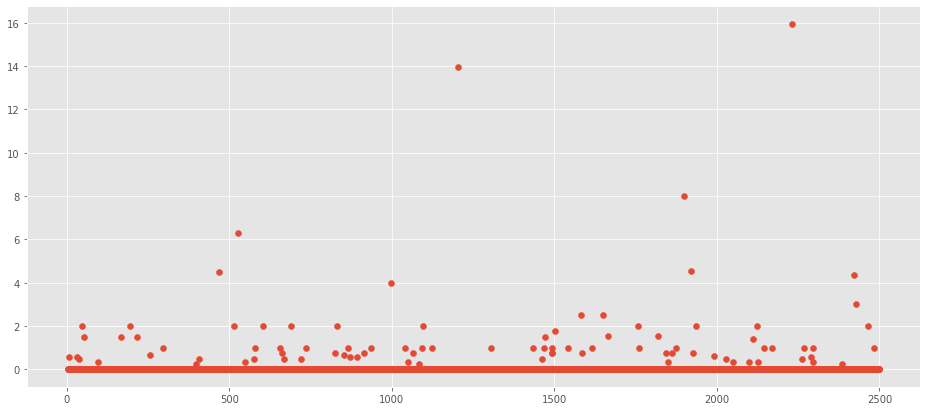

In [207]:
plt.scatter(x = money_per_household_per_category.index, y = money_per_household_per_category['Non-vegetarian'])

In [163]:
total = 0
for categ in categories:
    total += money_per_household_per_category[categ].sum()
    print('%s : %f' %(categ, money_per_household_per_category[categ].sum()))
print('Total: %f' %total)
print('Total should be %f' %money_per_household_per_category.Total.sum())

Meat : 2339.360000
Seafood : 303.440000
Sweet snacks : 6320.260000
Fruits : 570.330000
Vegetables : 1554.920000
Veg animal : 3019.240000
Beverage : 4827.220000
Condiments : 1739.090000
Carbs : 4024.360000
Meals : 4757.820000
Other : 22433.200000
Total: 51889.240000
Total should be 42611.540000


In [166]:
money_per_household_per_category.describe()

,Total,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other,Vegetarian,Non-vegetarian
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,17.044616,0.935744,0.121376,2.528104,0.228132,0.621968,1.207696,1.930888,0.695636,1.609744,1.903128,8.973280,3.667540,1.057120
std,41.401314,3.466967,1.954732,7.212516,0.964219,2.374646,3.599385,4.744003,2.236971,5.121943,5.981879,24.595031,10.539698,4.640186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.595000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,14.205000,0.350000,0.000000,2.000000,0.000000,0.000000,0.800000,2.500000,0.250000,1.000000,1.100000,6.510000,2.550000,0.500000
max,509.830000,71.800000,93.380000,84.670000,17.600000,48.880000,48.050000,71.710000,32.740000,80.830000,99.730000,315.050000,145.490000,153.510000


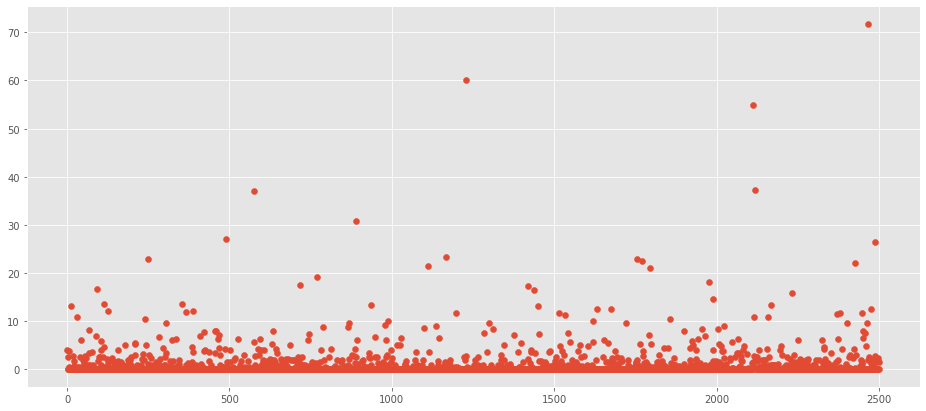

In [174]:
plt.scatter(x = money_per_household_per_category.index, y = money_per_household_per_category.Meat)

# Advertisement analysis

In [86]:
df_causal.head()

,product_id,store_id,week_no,display,mailer
0,26190,286,70,0,A
1,26190,288,70,0,A
2,26190,289,70,0,A
3,26190,292,70,0,A
4,26190,293,70,0,A


Let's start by changing the 'display' and 'mailer' values to make them more explicit. We will define two dict and then use the map() method for this.

In [87]:
display_dict = {'0':'Not on Display', '1':'Store Front', '2':'Store Rear', '3':'Front End Cap',
                '4':'Mid-Aisle End Cap', '5':'Read End Cap', '6':'Side-Aisle End Cap', '7':'In-Aisle' ,
                '9':'Secondary Location Display' ,'A':'In-Shelf' }
mailer_dict = {'0':'Not on ad', 'A':'Interior page feature', 'C':'Interior page line item', 
              'D':'Front page feature', 'F':'Back page feature', 'H':'Wrap front feature',
              'J':'Wrap interior coupon', 'L':'Wrap back feature', 'P':'Interior page coupon',
              'X':'Free on interior page', 'Z':'Free on front page, back page or wrap'}

In [88]:
df_causal.display = df_causal.display.apply(lambda x: str(x))
df_causal.display = df_causal.display.map(display_dict, na_action = 'ignore')
df_causal.mailer = df_causal.mailer.map(mailer_dict, na_action = 'ignore')

Let's observe how many products we have in each category, both for display and mailer.

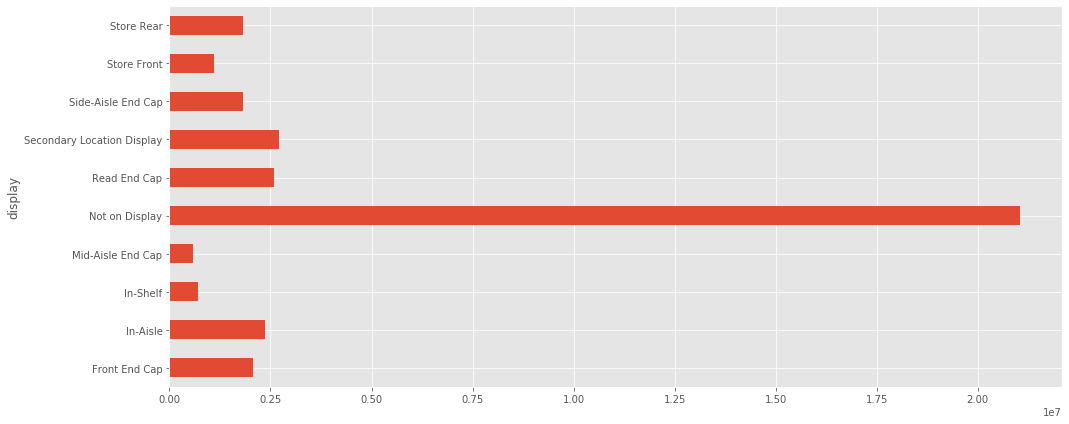

In [89]:
df_causal.groupby(by = 'display').count().mailer.plot(kind = 'barh')
plt.show()

As expected, many products are simply not in display.

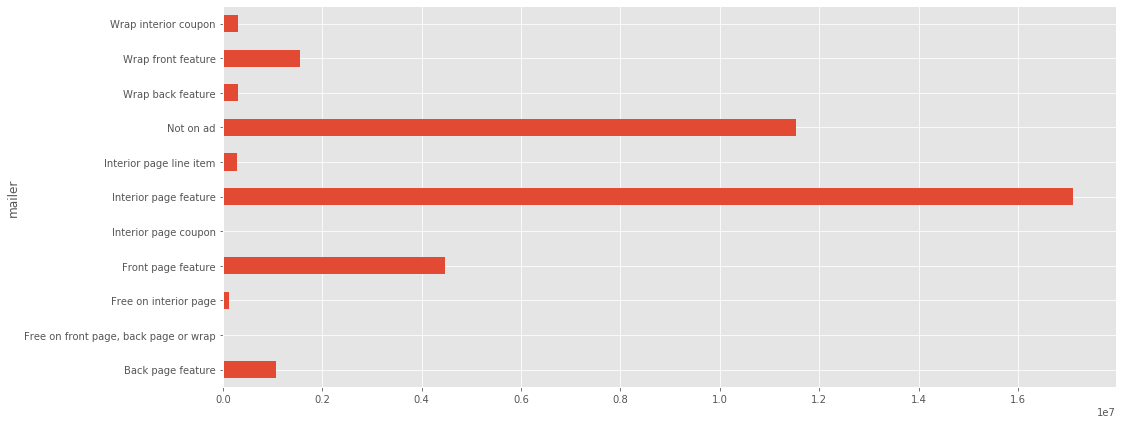

In [90]:
df_causal.groupby(by = 'mailer').count().display.plot(kind = 'barh')
plt.show()

As expected, the largest numbers of ads are in the interior or front pages.

Let's now analyse the ads distribution for each category of food previously defined. To do this, we will define a function ads_categories() that will take a dataframe (one of the 11 dataframes of the categories of food) and return the distribution of ads (as percentages). A show_plot parameter will decide if we want to directly plot the distribution in a bar plot.

In [91]:
def ads_categories(df, categ = '', show_plot = False):
    count = df.merge(df_causal, on = 'product_id').groupby(by = 'mailer').display.count()
    proportions = count.map(lambda x: 100*x/count.sum())
    
    if show_plot:
        proportions.plot.bar()
        plt.title('Proportion of mailer ads for %s' %categ)
        plt.xlabel('Type of ads')
        plt.xticks(rotation = 30)
        plt.ylabel('Proportion of ads [%]')
        plt.show()
    
    return (proportions,count)

Let's give an example for meat for instance.

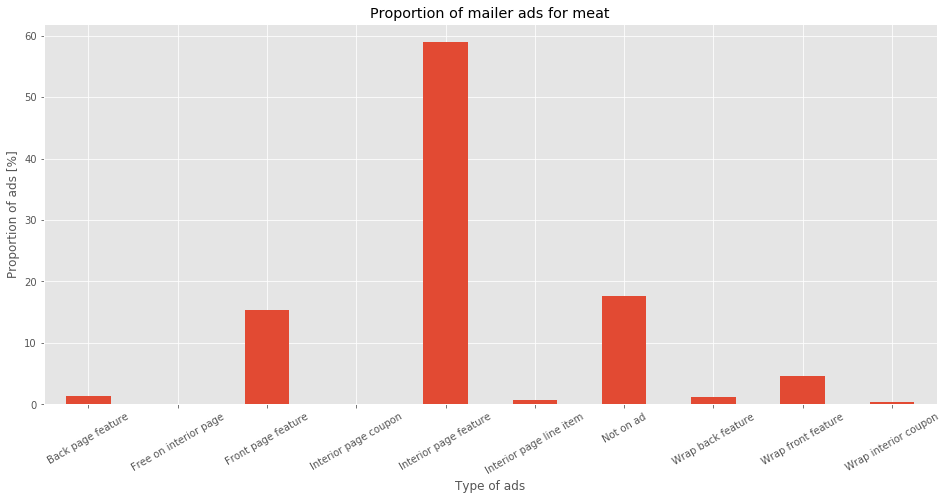

In [92]:
(prop_meat,count_meat) = ads_categories(df_meat, 'meat', True)

Let's create a dataframe to store the ads proportions for each category of food.

In [93]:
df_ads_prop = pd.DataFrame(index = mailer_dict.values(), columns = categories)
df_ads_prop.sort_index(inplace = True)
df_ads_prop.index.name = 'Type of ads'

df_ads_count = pd.DataFrame(index = mailer_dict.values(), columns = categories)
df_ads_count.sort_index(inplace = True)
df_ads_count.index.name = 'Type of ads'

In [94]:
for i,df in enumerate(df_list):
    df_ads_prop[categories[i]] = ads_categories(df)[0]
    df_ads_count[categories[i]] = ads_categories(df)[1]
df_ads_prop

,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other
Type of ads,,,,,,,,,,,
Back page feature,1.326539,0.409529,2.898073,42.638624,10.425027,0.259567,0.529633,0.868442,0.263158,6.433533,0.635639
"Free on front page, back page or wrap",NaN,NaN,0.148451,NaN,NaN,0.029404,NaN,0.000306,NaN,0.024577,0.001866
Free on interior page,0.137972,NaN,0.431924,NaN,NaN,0.215896,0.922489,0.232625,0.516948,0.078540,0.211327
Front page feature,15.291547,0.902767,9.680359,7.371521,9.686958,31.973922,21.871803,1.482297,10.532672,10.895891,1.138383
Interior page coupon,0.000439,0.019757,0.000133,0.000149,NaN,NaN,NaN,0.000077,NaN,0.001020,0.007387
Interior page feature,58.947636,51.109178,40.776344,22.743902,50.829157,46.992706,27.394318,50.844376,59.244924,53.490345,55.223489
Interior page line item,0.644314,1.183181,1.080173,1.064265,0.395106,0.868441,0.116542,1.049721,0.750130,0.499800,0.801908
Not on ad,17.596684,37.669410,39.163240,19.163329,18.270194,13.624105,43.829632,40.113466,21.384956,20.376264,38.518944
Wrap back feature,1.159260,0.397571,1.222001,0.968626,0.403883,0.246589,0.560094,1.220976,0.078185,0.692629,0.305043


We notice some values are set to NaN. This happens because, if there are no ads of the specific type of mailer, it is simply missing from the series. We can therefore simply fill all NaN values with 0.

In [95]:
df_ads_prop.fillna(0, inplace = True)
df_ads_count.fillna(0, inplace = True)
df_ads_prop.head()

,Meat,Seafood,Sweet snacks,Fruits,Vegetables,Veg animal,Beverage,Condiments,Carbs,Meals,Other
Type of ads,,,,,,,,,,,
Back page feature,1.326539,0.409529,2.898073,42.638624,10.425027,0.259567,0.529633,0.868442,0.263158,6.433533,0.635639
"Free on front page, back page or wrap",0.000000,0.000000,0.148451,0.000000,0.000000,0.029404,0.000000,0.000306,0.000000,0.024577,0.001866
Free on interior page,0.137972,0.000000,0.431924,0.000000,0.000000,0.215896,0.922489,0.232625,0.516948,0.078540,0.211327
Front page feature,15.291547,0.902767,9.680359,7.371521,9.686958,31.973922,21.871803,1.482297,10.532672,10.895891,1.138383
Interior page coupon,0.000439,0.019757,0.000133,0.000149,0.000000,0.000000,0.000000,0.000077,0.000000,0.001020,0.007387


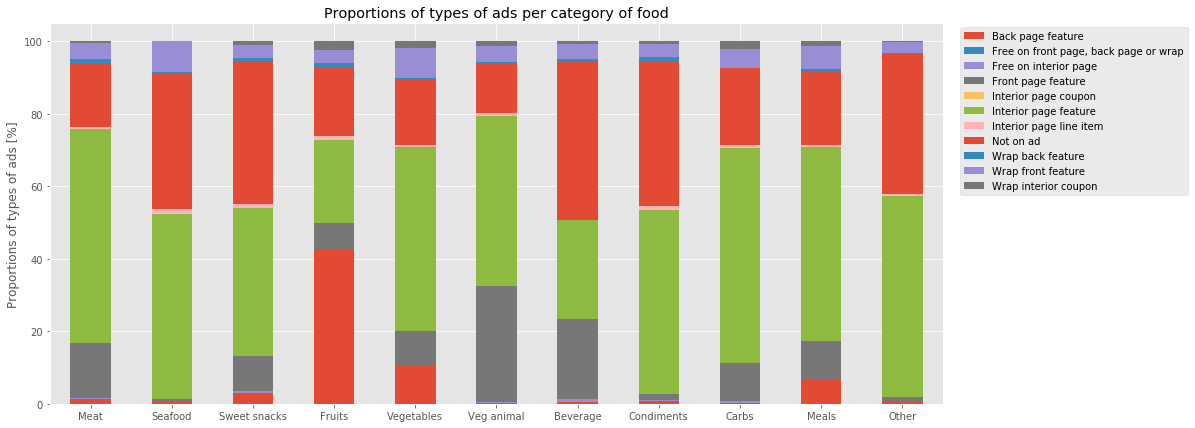

In [96]:
df_ads_prop.transpose().plot.bar(stacked = True) #The transpose() is needed to get the right kind of stacked barplot
plt.title('Proportions of types of ads per category of food')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Proportions of types of ads [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.28,0.77))
plt.show()

Let's look more precisely at Not on ad, Front page feature, Interior page feature and Back page feature.

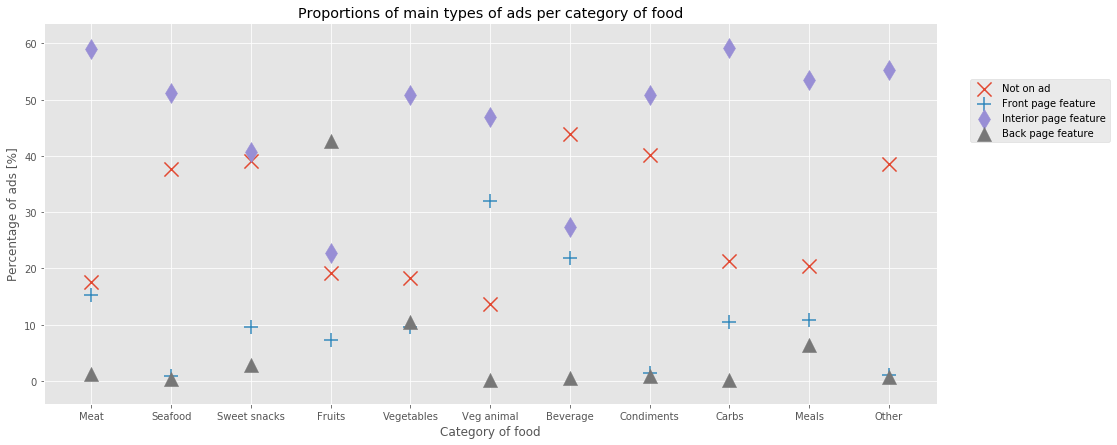

In [97]:
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Not on ad'], 
            label = 'Not on ad', marker = 'x', s = 200)
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Front page feature'], 
            label = 'Front page feature', marker = '+', s = 200)
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Interior page feature'], 
            label = 'Interior page feature', marker = 'd', s = 200)
plt.scatter(x = range(len(categories)), y = df_ads_prop.transpose()['Back page feature'], 
            label = 'Back page feature', marker = '^', s = 200)
plt.xticks(range(len(categories)), list(categories))
plt.title('Proportions of main types of ads per category of food')
plt.xlabel('Category of food')
plt.ylabel('Percentage of ads [%]')
plt.legend(loc = 5, bbox_to_anchor = (1.2,0.77))
plt.show()

We can see that meat ads are mainly situated in the interior pages with very few in the back pages. On the contrary, fruits have much more ads in the back pages.

# Price analysis

In this section, we will focus ourselfs on the prices of the products. We will start by some basic statistical analysis and then group products in the previously defined categories and try to extract some meaningful conclusions.

Let's clarify what the less obvious columns represent. The SALES_VALUE is the amount of dollar received by the retailer for a particular sale. The RETAIL_DISC is a discount applied due to retailer's loyalty card program. The COUPON_DISC is a discount applied due to manufacturer coupon and COUPON_MATCH_DISC a discount applied due to retailer's match of manufacturer coupon. Finally, the TRANS_TIME correspond to the time of the day the purchase was made (ranging from 0 to 2359, i.e. from 0:00 to 23:59)

In [ ]:
print('We have %d transactions in our dataset.' %len(df_transaction))
print('We have %d transactions in our dataset with QUANTITY = 0.' %len(df_transaction[df_transaction.quantity == 0]))

We start by discarding all transcations for which the quantity is null (as no item has actually been sold in these cases).

In [ ]:
df_transaction = df_transaction[df_transaction.quantity > 0]
print('We have %d transactions left in our dataset.' %len(df_transaction))

Let's add the actual product prices (with or without loyalty card). To do so, we use the following formulas (as explained in the user guide):
- Loyalty card price = (sales_value – (retail_disc + coupon_match_disc))/quantity
- Non-loyalty card price = (sales_value – coupon_match_disc)/quantity

In [ ]:
df_transaction['loyalty_card_price'] = (df_transaction['sales_value'] - (df_transaction['retail_disc'] + df_transaction['coupon_match_disc']))/df_transaction['quantity']
df_transaction['no_loyalty_card_price'] = (df_transaction['sales_value'] - df_transaction['coupon_match_disc'])/df_transaction['quantity']
df_transaction.head()

## Descriptive statistics

### Sales value

In [ ]:
stats.describe(df_transaction['sales_value'])

In [ ]:
print('50% of the transations are below ' + str(df_transaction['sales_value'].median()) + '$.')
print('80% of the transations are below ' + str(df_transaction['sales_value'].quantile(0.8)) + '$.')
print('There are %d transactions with sales value 0.' %len(df_transaction[df_transaction['sales_value'] == 0]))

### Actual price (with and without loyalty card)

In [ ]:
stats.describe(df_transaction['loyalty_card_price'])

In [ ]:
print('50% of the prices (with loyalty card) are below ' + str(df_transaction['loyalty_card_price'].median()) + '$.')
print('80% of the prices (with loyalty card) are below ' + str(df_transaction['loyalty_card_price'].quantile(0.8)) + '$.')

In [ ]:
stats.describe(df_transaction['no_loyalty_card_price'])

In [ ]:
print('50% of the prices (without loyalty card) are below ' + str(df_transaction['no_loyalty_card_price'].median()) + '$.')
print('80% of the prices (without loyalty card) are below ' + str(df_transaction['no_loyalty_card_price'].quantile(0.8)) + '$.')

### Discounts (retailer and coupons)

In [ ]:
stats.describe(df_transaction['retail_disc'])

In [ ]:
stats.describe(df_transaction['coupon_disc'])

In [ ]:
stats.describe(df_transaction['coupon_match_disc'])

### Transaction time

In [ ]:
print('The TRANS_TIME ranges between %d and %d.' %(df_transaction['trans_time'].min(), df_transaction['trans_time'].max()))

# Demographics and Food

Can we see if there are different buying habits for older/younger peopl? Let's start by combining our demographic data with the transactions. Then we'll annotate all transactions, if they're meat or other food.

In [ ]:
df_transaction_per_household = df_transaction.merge(df_demo, on="household_key")

df_transaction_per_household["category"] = "unknown"

# First, let's mark everything that is food
df_transaction_per_household.loc[
    df_transaction_per_household["product_id"].isin(df_food["product_id"]), "category"
] = "other-food"

# Then we overwrite all entries that are actually meat
df_transaction_per_household.loc[
    df_transaction_per_household["product_id"].isin(df_meat["product_id"]), "category"
] = "meat"

df_transaction_per_household

Now we'll create a temporary dataframe to compute a meat ratio for each for each household. We do this by grouping by the households and then doing the calculation:

In [ ]:
aa = (
    df_transaction_per_household.groupby("household_key")["category"]
    .value_counts()
    .to_frame()
    .unstack()
)

# Drop the multi-columns, so we can
# use simple indexing for ratio_meat
aa.columns = aa.columns.droplevel()

aa["ratio_meat"] = aa["meat"] / (aa["meat"] + aa["other-food"])

# Get household_key as a column
aa = aa.reset_index()

aa

Now we combine our data to receive a new dataframe that enriches our existing demographic dataframe with a "meat ratio". This ratio tells us, how much of the bought food is considered meat.

In [ ]:
# Combine our newly computed ratio_meat and the old household data
df_demo_w_meat = df_demo.merge(aa[["household_key", "ratio_meat"]], on="household_key")

# Normalize our ratio_meat by the size of the households
df_demo_w_meat["ratio_meat"] /= df_demo_w_meat["household_size_desc_numeric"]

df_demo_w_meat

Now to get a sense of the data, we'll plot it. Grouped by three different attributes: marital status, age and income

In [ ]:
salary_index = [
    "Under 15K",
    "15-24K",
    "25-34K",
    "35-49K",
    "50-74K",
    "75-99K",
    "100-124K",
    "125-149K",
    "150-174K",
    "175-199K",
    "200-249K",
    "250K+",
]

fig, axes = plt.subplots(nrows=3)
interesting_groups = ["age_desc", "married", "income_desc"]

for i, group_name in enumerate(interesting_groups):
    data = df_demo_w_meat.groupby(group_name).ratio_meat.mean()
    
    qupper = df_demo_w_meat.groupby(group_name).ratio_meat.quantile(0.975)
    qlower = df_demo_w_meat.groupby(group_name).ratio_meat.quantile(0.025)
    
    if group_name == "income_desc":
        data = data.reindex(salary_index)
    
    data.plot(kind="bar", ax=axes[i], yerr=[data - qlower, qupper - data], capsize=10)
    
    axes[i].set_ylabel("Percentage of meat of overall shoppings")

fig.suptitle("Percentages of meat purchases (95% CI)")
fig.set_figheight(22)
plt.show()

We see two interesting things:

- Married people seem to buy less food (might be that they buy fewer, but larger packs)
- As the income rises, the amount of meat bought decreases. It then sharply increases for incomes of over 250k

# Milestone 3

### What's coming next

* *Campaign and coupons analysis:* continue our analysis on how retailers promote different categories of food and how people respond to it. In practice, this means for instance combining what has already been done with the transactions to find out how much people save money thanks to these campaigns and if it differs from one category of food to another.

* *Household behaviour:* continue our analysis on the demographics in order to find different behaviour (due to income or type of family) towards meat consumption and vegetarianism in general.

* *Advertisement analysis:* continue analysis (look at both distribution of ads within one category of food and across all categories, which ones get more ads in the best displays) and combine results with campaign and coupons analysis.

Ultimately, our goal would be to combine more and more our results in order to get a precise understanding of both retailers and consumers towards meat consumption and vegetarianism in general.